In [1]:
import easydict
import json
import datetime
import re

In [2]:
args = easydict.EasyDict()

args.default_path = "../data/encore21titanic/"
args.train_csv = args.default_path+"train.csv"
args.test_csv = args.default_path+"test.csv"
args.submission_csv = args.default_path+"submission.csv"

args.random_state = 21

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [4]:
scores = []

# 데이터 불러오기

In [5]:
train = pd.read_csv(args.train_csv)
print(train.shape)
train.head()

(916, 12)


,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,0,2,"Wheeler, Mr. Edwin Frederick""""",male,NaN,0,0,SC/PARIS 2159,12.8750,NaN,S
1,1,0,3,"Henry, Miss. Delia",female,NaN,0,0,382649,7.7500,NaN,Q
2,2,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",female,52.0,1,1,12749,93.5000,B69,S
3,3,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S
4,4,0,2,"Hold, Mr. Stephen",male,44.0,1,0,26707,26.0000,NaN,S


In [6]:
test = pd.read_csv(args.test_csv)
print(test.shape)
test.head()

(393, 11)


,passengerid,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
0,916,3,"McGowan, Miss. Anna ""Annie""",female,15.0,0,0,330923,8.0292,NaN,Q
1,917,2,"Pinsky, Mrs. (Rosa)",female,32.0,0,0,234604,13.0000,NaN,S
2,918,3,"McCarthy, Miss. Catherine Katie""""",female,NaN,0,0,383123,7.7500,NaN,Q
3,919,3,"Franklin, Mr. Charles (Charles Fardon)",male,NaN,0,0,SOTON/O.Q. 3101314,7.2500,NaN,S
4,920,1,"Wick, Mrs. George Dennick (Mary Hitchcock)",female,45.0,1,1,36928,164.8667,NaN,S


In [7]:
submission = pd.read_csv(args.submission_csv)
print(submission.shape)
submission

(393, 2)


,passengerid,survived
0,916,0.5
1,917,0.5
2,918,0.5
3,919,0.5
4,920,0.5
...,...,...
388,1304,0.5
389,1305,0.5
390,1306,0.5
391,1307,0.5


## train, validate 데이터 분리

In [8]:
train.drop(["survived"], axis=1)

,passengerid,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked
0,0,2,"Wheeler, Mr. Edwin Frederick""""",male,NaN,0,0,SC/PARIS 2159,12.8750,NaN,S
1,1,3,"Henry, Miss. Delia",female,NaN,0,0,382649,7.7500,NaN,Q
2,2,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",female,52.0,1,1,12749,93.5000,B69,S
3,3,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",male,27.0,0,0,350043,7.7958,NaN,S
4,4,2,"Hold, Mr. Stephen",male,44.0,1,0,26707,26.0000,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
911,911,3,"Thomas, Mr. Charles P",male,NaN,1,0,2621,6.4375,NaN,C
912,912,3,"Cacic, Mr. Jego Grga",male,18.0,0,0,315091,8.6625,NaN,S
913,913,2,"Pengelly, Mr. Frederick William",male,19.0,0,0,28665,10.5000,NaN,S
914,914,3,"Mullens, Miss. Katherine ""Katie""",female,NaN,0,0,35852,7.7333,NaN,Q


In [9]:
X_tr, X_va, y_tr, y_va = train_test_split(train.drop(["survived"], axis=1), train["survived"], test_size=0.33, random_state=args["random_state"])
X_tr.shape, X_va.shape, y_tr.shape, y_va.shape

((613, 11), (303, 11), (613,), (303,))

# EDA

## 데이터 분리

In [10]:
train.columns

Index(['passengerid', 'survived', 'pclass', 'name', 'gender', 'age', 'sibsp',
       'parch', 'ticket', 'fare', 'cabin', 'embarked'],
      dtype='object')

In [11]:
# id는 필요없으므로 drop
X_tr.drop("passengerid", axis=1, inplace=True)
X_va.drop("passengerid", axis=1, inplace=True)

In [12]:
train_number = train.select_dtypes(np.number)
train_number.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  916 non-null    int64  
 1   survived     916 non-null    int64  
 2   pclass       916 non-null    int64  
 3   age          736 non-null    float64
 4   sibsp        916 non-null    int64  
 5   parch        916 non-null    int64  
 6   fare         916 non-null    float64
dtypes: float64(2), int64(5)
memory usage: 50.2 KB


In [13]:
train_object = train.select_dtypes(exclude=np.number)
train_object.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   name      916 non-null    object
 1   gender    916 non-null    object
 2   ticket    916 non-null    object
 3   cabin     198 non-null    object
 4   embarked  915 non-null    object
dtypes: object(5)
memory usage: 35.9+ KB


## 수치형 데이터 분석

In [14]:
train_number.corr()

,passengerid,survived,pclass,age,sibsp,parch,fare
passengerid,1.000000,-0.006293,0.051875,-0.038481,0.003418,-0.039941,-0.063073
survived,-0.006293,1.000000,-0.250455,-0.030330,0.002924,0.084269,0.224068
pclass,0.051875,-0.250455,1.000000,-0.407876,0.069781,0.060049,-0.541277
age,-0.038481,-0.030330,-0.407876,1.000000,-0.255825,-0.169893,0.139101
sibsp,0.003418,0.002924,0.069781,-0.255825,1.000000,0.386491,0.162144
parch,-0.039941,0.084269,0.060049,-0.169893,0.386491,1.000000,0.181826
fare,-0.063073,0.224068,-0.541277,0.139101,0.162144,0.181826,1.000000


<AxesSubplot: >

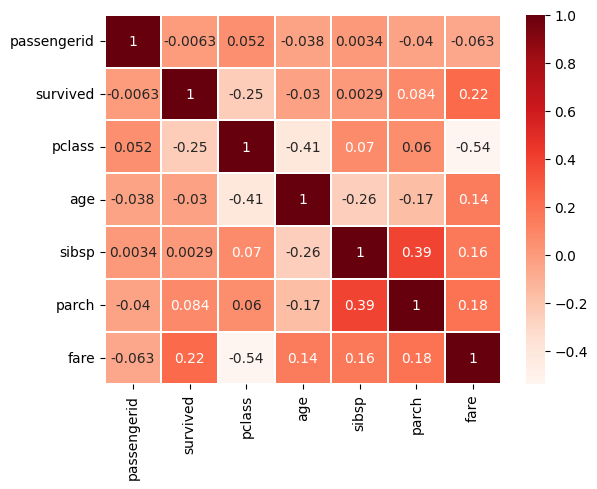

In [15]:
sns.heatmap(train_number.corr(), annot=True, linewidths=0.2, cmap='Reds')

### pclass

In [16]:
# 이산형 데이터
train_number["pclass"]

0      2
1      3
2      1
3      3
4      2
      ..
911    3
912    3
913    2
914    3
915    1
Name: pclass, Length: 916, dtype: int64

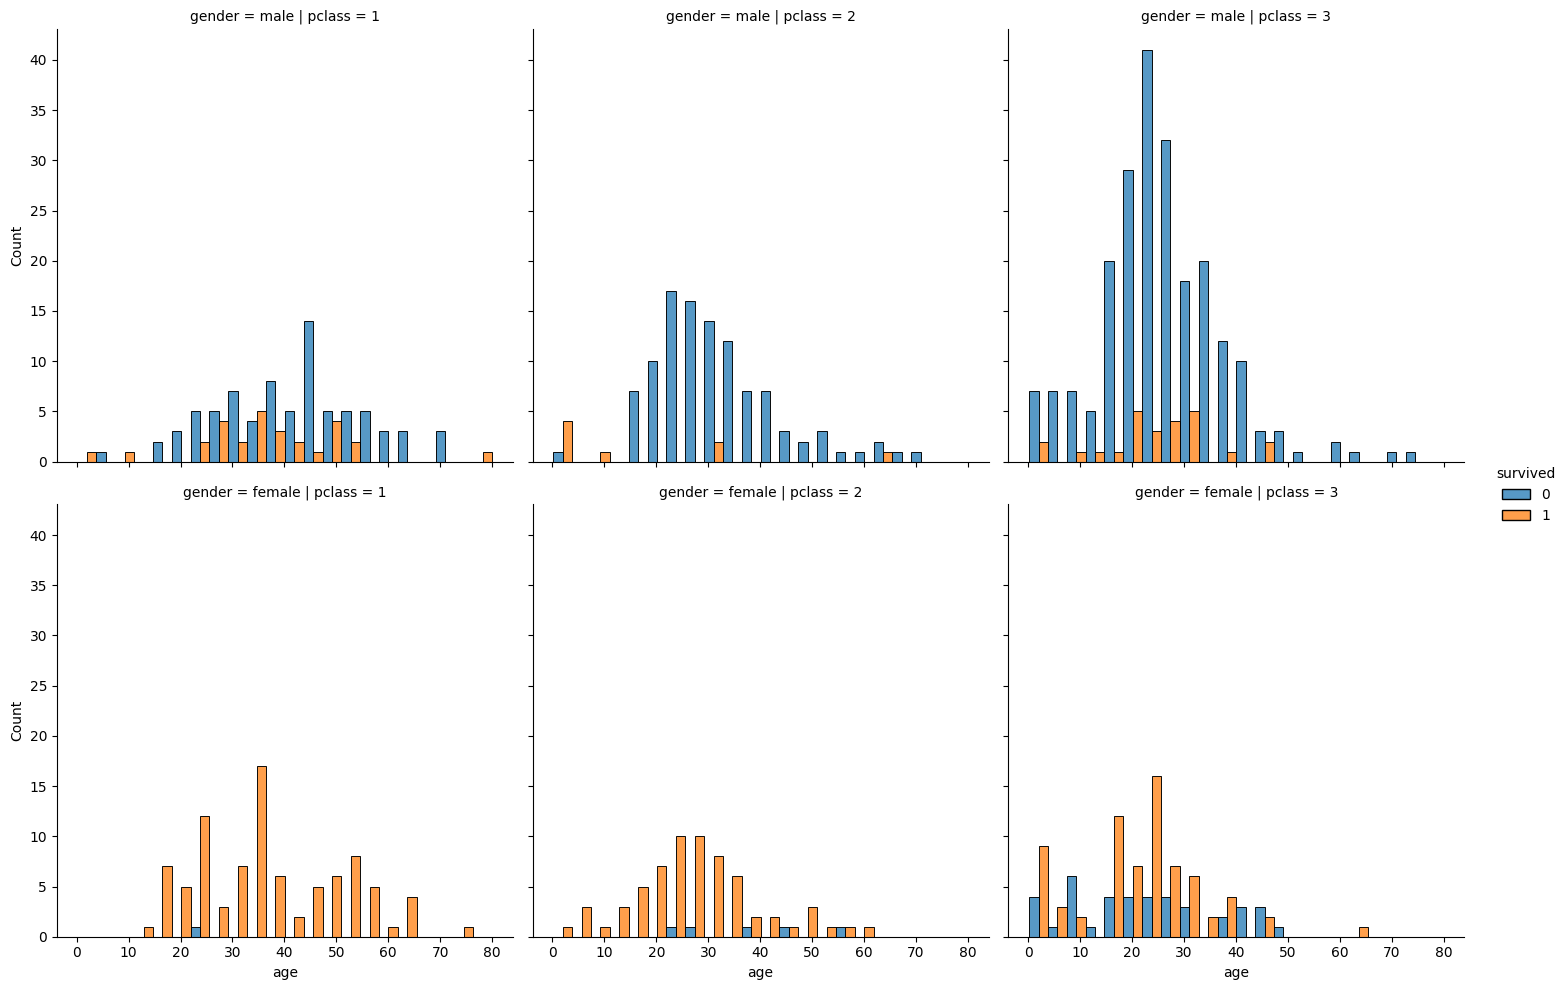

In [17]:
sns.displot(train, x="age", multiple="dodge", hue="survived", col="pclass", row="gender")

### age

In [18]:
# 10년단위 세대 feature 추가
train_number["age_decades"] = train_number["age"] // 10
train["age_decades"] = train_number["age_decades"]
train_number

,passengerid,survived,pclass,age,sibsp,parch,fare,age_decades
0,0,0,2,NaN,0,0,12.8750,NaN
1,1,0,3,NaN,0,0,7.7500,NaN
2,2,1,1,52.0,1,1,93.5000,5.0
3,3,1,3,27.0,0,0,7.7958,2.0
4,4,0,2,44.0,1,0,26.0000,4.0
...,...,...,...,...,...,...,...,...
911,911,0,3,NaN,1,0,6.4375,NaN
912,912,0,3,18.0,0,0,8.6625,1.0
913,913,0,2,19.0,0,0,10.5000,1.0
914,914,1,3,NaN,0,0,7.7333,NaN


In [19]:
test["age_decades"] = test["age"] // 10
test

,passengerid,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,age_decades
0,916,3,"McGowan, Miss. Anna ""Annie""",female,15.0,0,0,330923,8.0292,NaN,Q,1.0
1,917,2,"Pinsky, Mrs. (Rosa)",female,32.0,0,0,234604,13.0000,NaN,S,3.0
2,918,3,"McCarthy, Miss. Catherine Katie""""",female,NaN,0,0,383123,7.7500,NaN,Q,NaN
3,919,3,"Franklin, Mr. Charles (Charles Fardon)",male,NaN,0,0,SOTON/O.Q. 3101314,7.2500,NaN,S,NaN
4,920,1,"Wick, Mrs. George Dennick (Mary Hitchcock)",female,45.0,1,1,36928,164.8667,NaN,S,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...
388,1304,3,"Healy, Miss. Hanora ""Nora""",female,NaN,0,0,370375,7.7500,NaN,Q,NaN
389,1305,1,"Hippach, Miss. Jean Gertrude",female,16.0,0,1,111361,57.9792,B18,C,1.0
390,1306,3,"Ayoub, Miss. Banoura",female,13.0,0,0,2687,7.2292,NaN,C,1.0
391,1307,3,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",female,39.0,1,5,347082,31.2750,NaN,S,3.0


### sibsp & parch

In [20]:
# 가족이 있는지에 대한 feature 추가
train_number["has_family"] = 0
train_number.loc[(train_number["sibsp"] != 0) | (train_number["parch"] != 0), "has_family"] = 1
train["has_family"] = train_number["has_family"]
train_number

,passengerid,survived,pclass,age,sibsp,parch,fare,age_decades,has_family
0,0,0,2,NaN,0,0,12.8750,NaN,0
1,1,0,3,NaN,0,0,7.7500,NaN,0
2,2,1,1,52.0,1,1,93.5000,5.0,1
3,3,1,3,27.0,0,0,7.7958,2.0,0
4,4,0,2,44.0,1,0,26.0000,4.0,1
...,...,...,...,...,...,...,...,...,...
911,911,0,3,NaN,1,0,6.4375,NaN,1
912,912,0,3,18.0,0,0,8.6625,1.0,0
913,913,0,2,19.0,0,0,10.5000,1.0,0
914,914,1,3,NaN,0,0,7.7333,NaN,0


In [21]:
test["has_family"] = 0
test.loc[(test["sibsp"] != 0) | (test["parch"] != 0), "has_family"] = 1
test

,passengerid,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,age_decades,has_family
0,916,3,"McGowan, Miss. Anna ""Annie""",female,15.0,0,0,330923,8.0292,NaN,Q,1.0,0
1,917,2,"Pinsky, Mrs. (Rosa)",female,32.0,0,0,234604,13.0000,NaN,S,3.0,0
2,918,3,"McCarthy, Miss. Catherine Katie""""",female,NaN,0,0,383123,7.7500,NaN,Q,NaN,0
3,919,3,"Franklin, Mr. Charles (Charles Fardon)",male,NaN,0,0,SOTON/O.Q. 3101314,7.2500,NaN,S,NaN,0
4,920,1,"Wick, Mrs. George Dennick (Mary Hitchcock)",female,45.0,1,1,36928,164.8667,NaN,S,4.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
388,1304,3,"Healy, Miss. Hanora ""Nora""",female,NaN,0,0,370375,7.7500,NaN,Q,NaN,0
389,1305,1,"Hippach, Miss. Jean Gertrude",female,16.0,0,1,111361,57.9792,B18,C,1.0,1
390,1306,3,"Ayoub, Miss. Banoura",female,13.0,0,0,2687,7.2292,NaN,C,1.0,0
391,1307,3,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",female,39.0,1,5,347082,31.2750,NaN,S,3.0,1


### fare

In [22]:
# 요금 범위를 구하기 위한 요금/10 feature 추가
train_number["fare_div10"] = train_number["fare"] // 10
train["fare_div10"] = train_number["fare_div10"]
train_number["fare_div10"]

0      1.0
1      0.0
2      9.0
3      0.0
4      2.0
      ... 
911    0.0
912    0.0
913    1.0
914    0.0
915    2.0
Name: fare_div10, Length: 916, dtype: float64

In [23]:
test["fare_div10"] = test["fare"] // 10
test["fare_div10"]

0       0.0
1       1.0
2       0.0
3       0.0
4      16.0
       ... 
388     0.0
389     5.0
390     0.0
391     3.0
392     0.0
Name: fare_div10, Length: 393, dtype: float64

In [24]:
cols = ["pclass", "age", "sibsp", "parch", "fare"]
tr_num = train[cols]
te_num = test[cols]
tr_num.describe()

,pclass,age,sibsp,parch,fare
count,916.000000,736.000000,916.000000,916.000000,916.000000
mean,2.292576,29.698370,0.507642,0.361354,32.402710
std,0.838675,14.185627,1.044866,0.828054,50.506411
min,1.000000,0.170000,0.000000,0.000000,0.000000
25%,2.000000,21.000000,0.000000,0.000000,7.895800
50%,3.000000,28.000000,0.000000,0.000000,14.458300
75%,3.000000,38.000000,1.000000,0.000000,30.017700
max,3.000000,80.000000,8.000000,9.000000,512.329200


## 범주형 데이터 분석

In [25]:
train_object.describe()

,name,gender,ticket,cabin,embarked
count,916,916,916,198,915
unique,915,2,703,146,3
top,"Connolly, Miss. Kate",male,CA. 2343,G6,S
freq,2,589,7,4,645


### gender

In [26]:
# 성별을 0과 1로 치환
train_object["gender"].replace({"male": 1, "female": 0}, inplace=True)
train["gender"].replace({"male": 1, "female": 0}, inplace=True)
test["gender"].replace({"male": 1, "female": 0}, inplace=True)

### name

In [27]:
name_header = re.compile("[a-zA-Z]+\, [ a-zA-Z]+\.")

In [28]:
name_headers = [name_header.search(x).group().strip() for x in train_object["name"]]
name_headers[:5]

['Wheeler, Mr.', 'Henry, Miss.', 'Hays, Mrs.', 'Andersson, Mr.', 'Hold, Mr.']

In [29]:
name_headers_t = [name_header.search(x).group().strip() for x in test["name"]]

In [30]:
name_family = re.compile("[a-zA-Z]+\, ")

In [31]:
name_families = [name_family.search(x).group().strip().replace(",", "") for x in name_headers]
name_families = pd.DataFrame(name_families, columns=["name_family"])
name_families

,name_family
0,Wheeler
1,Henry
2,Hays
3,Andersson
4,Hold
...,...
911,Thomas
912,Cacic
913,Pengelly
914,Mullens


In [32]:
name_families_t = [name_family.search(x).group().strip().replace(",", "") for x in name_headers_t]

In [33]:
name_families.describe()

,name_family
count,916
unique,672
top,Andersson
freq,7


In [34]:
name_title = re.compile(" [ a-zA-Z]+\.")

In [35]:
name_titles = [name_title.search(x).group().strip() for x in name_headers]
name_titles = pd.DataFrame(name_titles, columns=["name_title"])
name_titles

,name_title
0,Mr.
1,Miss.
2,Mrs.
3,Mr.
4,Mr.
...,...
911,Mr.
912,Mr.
913,Mr.
914,Miss.


In [36]:
name_titles_t = [name_title.search(x).group().strip() for x in name_headers_t]
name_titles_t = pd.DataFrame(name_titles_t, columns=["name_title"])
name_titles_t

,name_title
0,Miss.
1,Mrs.
2,Miss.
3,Mr.
4,Mrs.
...,...
388,Miss.
389,Miss.
390,Miss.
391,Mrs.


In [37]:
name_titles["name_title"].unique()

array(['Mr.', 'Miss.', 'Mrs.', 'Master.', 'Col.', 'Dr.', 'Rev.', 'Don.',
       'Ms.', 'Major.', 'Jonkheer.', 'Mlle.', 'the Countess.', 'Capt.',
       'Sir.'], dtype=object)

In [38]:
name_titles_t["name_title"].unique()

array(['Miss.', 'Mrs.', 'Mr.', 'Master.', 'Rev.', 'Dona.', 'Dr.', 'Lady.',
       'Mme.', 'Mlle.', 'Col.', 'Ms.'], dtype=object)

In [39]:
pd.concat([name_titles["name_title"], name_titles_t["name_title"]]).unique()

array(['Mr.', 'Miss.', 'Mrs.', 'Master.', 'Col.', 'Dr.', 'Rev.', 'Don.',
       'Ms.', 'Major.', 'Jonkheer.', 'Mlle.', 'the Countess.', 'Capt.',
       'Sir.', 'Dona.', 'Lady.', 'Mme.'], dtype=object)

In [40]:
np.setdiff1d(name_titles_t["name_title"].unique(), name_titles["name_title"].unique())

array(['Dona.', 'Lady.', 'Mme.'], dtype=object)

In [41]:
train["name_title"], train["name_family"] = name_titles["name_title"], name_families["name_family"]
train.head()

,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,age_decades,has_family,fare_div10,name_title,name_family
0,0,0,2,"Wheeler, Mr. Edwin Frederick""""",1,NaN,0,0,SC/PARIS 2159,12.8750,NaN,S,NaN,0,1.0,Mr.,Wheeler
1,1,0,3,"Henry, Miss. Delia",0,NaN,0,0,382649,7.7500,NaN,Q,NaN,0,0.0,Miss.,Henry
2,2,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",0,52.0,1,1,12749,93.5000,B69,S,5.0,1,9.0,Mrs.,Hays
3,3,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",1,27.0,0,0,350043,7.7958,NaN,S,2.0,0,0.0,Mr.,Andersson
4,4,0,2,"Hold, Mr. Stephen",1,44.0,1,0,26707,26.0000,NaN,S,4.0,1,2.0,Mr.,Hold


In [42]:
test["name_title"], test["name_family"] = name_titles_t, name_families_t
test.head()

,passengerid,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,age_decades,has_family,fare_div10,name_title,name_family
0,916,3,"McGowan, Miss. Anna ""Annie""",0,15.0,0,0,330923,8.0292,NaN,Q,1.0,0,0.0,Miss.,McGowan
1,917,2,"Pinsky, Mrs. (Rosa)",0,32.0,0,0,234604,13.0000,NaN,S,3.0,0,1.0,Mrs.,Pinsky
2,918,3,"McCarthy, Miss. Catherine Katie""""",0,NaN,0,0,383123,7.7500,NaN,Q,NaN,0,0.0,Miss.,McCarthy
3,919,3,"Franklin, Mr. Charles (Charles Fardon)",1,NaN,0,0,SOTON/O.Q. 3101314,7.2500,NaN,S,NaN,0,0.0,Mr.,Franklin
4,920,1,"Wick, Mrs. George Dennick (Mary Hitchcock)",0,45.0,1,1,36928,164.8667,NaN,S,4.0,1,16.0,Mrs.,Wick


In [43]:
test.loc[(test["name_title"] == 'Dona.') | (test["name_title"] == 'Lady.') | (test["name_title"] ==  'Mme.')]

,passengerid,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,age_decades,has_family,fare_div10,name_title,name_family
52,968,1,"Oliva y Ocana, Dona. Fermina",0,39.0,0,0,PC 17758,108.9,C105,C,3.0,0,10.0,Dona.,Ocana
123,1039,1,"Duff Gordon, Lady. (Lucille Christiana Sutherl...",0,48.0,1,0,11755,39.6,A16,C,4.0,1,3.0,Lady.,Gordon
135,1051,1,"Aubart, Mme. Leontine Pauline",0,24.0,0,0,PC 17477,69.3,B35,C,2.0,0,6.0,Mme.,Aubart


In [44]:
titles = {
    'Mr.':1,
    'Miss.':2,
    'Mrs.':3,
    'Master.':4,
    'Col.':4,
    'Dr.':4,
    'Rev.':4,
    'Don.':4,
    'Ms.':2,
    'Major.':4,
    'Jonkheer.':4,
    'Mlle.':4,
    'the Countess.':4,
    'Capt.':4,
    'Sir.':3,
    'Dona.':3,
    'Lady.':3,
    'Mme.':3,
    1:1,
    2:2,
    3:3,
    4:4,
}

In [45]:
train["name_title"].replace(titles, inplace=True)
train[:5]

,passengerid,survived,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,age_decades,has_family,fare_div10,name_title,name_family
0,0,0,2,"Wheeler, Mr. Edwin Frederick""""",1,NaN,0,0,SC/PARIS 2159,12.8750,NaN,S,NaN,0,1.0,1,Wheeler
1,1,0,3,"Henry, Miss. Delia",0,NaN,0,0,382649,7.7500,NaN,Q,NaN,0,0.0,2,Henry
2,2,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",0,52.0,1,1,12749,93.5000,B69,S,5.0,1,9.0,3,Hays
3,3,1,3,"Andersson, Mr. August Edvard (""Wennerstrom"")",1,27.0,0,0,350043,7.7958,NaN,S,2.0,0,0.0,1,Andersson
4,4,0,2,"Hold, Mr. Stephen",1,44.0,1,0,26707,26.0000,NaN,S,4.0,1,2.0,1,Hold


In [46]:
test["name_title"].replace(titles, inplace=True)
test[:5]

,passengerid,pclass,name,gender,age,sibsp,parch,ticket,fare,cabin,embarked,age_decades,has_family,fare_div10,name_title,name_family
0,916,3,"McGowan, Miss. Anna ""Annie""",0,15.0,0,0,330923,8.0292,NaN,Q,1.0,0,0.0,2,McGowan
1,917,2,"Pinsky, Mrs. (Rosa)",0,32.0,0,0,234604,13.0000,NaN,S,3.0,0,1.0,3,Pinsky
2,918,3,"McCarthy, Miss. Catherine Katie""""",0,NaN,0,0,383123,7.7500,NaN,Q,NaN,0,0.0,2,McCarthy
3,919,3,"Franklin, Mr. Charles (Charles Fardon)",1,NaN,0,0,SOTON/O.Q. 3101314,7.2500,NaN,S,NaN,0,0.0,1,Franklin
4,920,1,"Wick, Mrs. George Dennick (Mary Hitchcock)",0,45.0,1,1,36928,164.8667,NaN,S,4.0,1,16.0,3,Wick


In [47]:
train[["survived", "pclass", "gender", "cabin", "embarked", "ticket", "name_family"]].sort_values(["name_family"])

,survived,pclass,gender,cabin,embarked,ticket,name_family
515,1,2,0,NaN,C,P/PP 3381,Abelson
215,0,2,1,NaN,C,P/PP 3381,Abelson
886,1,3,0,NaN,C,2657,Abrahim
431,0,3,1,NaN,S,C 7076,Adahl
151,0,3,1,NaN,S,341826,Adams
...,...,...,...,...,...,...,...
339,1,1,0,C32,C,PC 17760,Young
632,0,3,1,NaN,C,2627,Yousseff
348,0,2,0,NaN,S,248747,Yrois
91,0,3,0,NaN,C,2665,Zabour


### ticket

In [48]:
train_object.drop(["gender"], axis=1).describe()

,name,ticket,cabin,embarked
count,916,916,198,915
unique,915,703,146,3
top,"Connolly, Miss. Kate",CA. 2343,G6,S
freq,2,7,4,645


In [49]:
counts = train["name_family"].value_counts()

In [50]:
train[["survived", "pclass", "gender", "ticket", "cabin", "name_family"]].loc[train["name_family"] == "Newell"]

,survived,pclass,gender,ticket,cabin,name_family
153,0,1,1,35273,D48,Newell
463,1,1,0,35273,D36,Newell
472,1,1,0,35273,D36,Newell


In [51]:
train[["survived", "pclass", "gender", "ticket", "cabin", "name_family"]].loc[train["name_family"] == "Sage"]

,survived,pclass,gender,ticket,cabin,name_family
13,0,3,0,CA. 2343,NaN,Sage
77,1,3,0,CA. 2343,NaN,Sage
330,0,3,1,CA. 2343,NaN,Sage
380,1,3,0,CA. 2343,NaN,Sage
583,0,3,1,CA. 2343,NaN,Sage
752,0,3,1,CA. 2343,NaN,Sage
822,0,3,1,CA. 2343,NaN,Sage


In [52]:
train[["survived", "pclass", "gender", "ticket", "cabin", "name_family"]].loc[train["name_family"] == "Goodwin"]

,survived,pclass,gender,ticket,cabin,name_family
28,1,3,0,CA 2144,NaN,Goodwin
173,0,3,1,CA 2144,NaN,Goodwin
464,0,3,1,CA 2144,NaN,Goodwin
481,0,3,1,CA 2144,NaN,Goodwin
529,0,3,0,CA 2144,NaN,Goodwin
791,0,3,1,CA 2144,NaN,Goodwin


In [53]:
train[["survived", "pclass", "gender", "ticket", "cabin", "name_family"]].loc[train["name_family"] == "Panula"]

,survived,pclass,gender,ticket,cabin,name_family
94,0,3,1,3101295,NaN,Panula
111,0,3,1,3101295,NaN,Panula
241,0,3,1,3101295,NaN,Panula
643,0,3,1,3101295,NaN,Panula
763,0,3,0,3101295,NaN,Panula
848,0,3,1,3101295,NaN,Panula


하다보니 ticket이 같은 사람들에 대한 연관성을 찾을 수가 없다.  
폐기 결정.

In [54]:
train_object.drop(["ticket"], axis=1, inplace=True)
train.drop(["ticket"], axis=1, inplace=True)
test.drop(["ticket"], axis=1, inplace=True)

### cabin

결측치가 너무 많고 그나마 있는것도 생존과 연관하기 어려워 보임.  
폐기 결정.

In [55]:
train_object.drop(["cabin"], axis=1, inplace=True)
train.drop(["cabin"], axis=1, inplace=True)
test.drop(["cabin"], axis=1, inplace=True)

### embarked

In [56]:
train["embarked"].unique()

array(['S', 'Q', 'C', nan], dtype=object)

In [57]:
embarked = {
    'S': 1,
    'Q': 2,
    'C': 3,
    1: 1,
    2: 2,
    3: 3
}

In [58]:
train["embarked_e"] = train["embarked"].replace(embarked)
test["embarked_e"] = test["embarked"].replace(embarked)
train["embarked_e"]

0      1.0
1      2.0
2      1.0
3      1.0
4      1.0
      ... 
911    3.0
912    1.0
913    1.0
914    2.0
915    3.0
Name: embarked_e, Length: 916, dtype: float64

In [59]:
train.shape, test.shape

((916, 16), (393, 15))

# 결측치 확인

In [60]:
ori_train = pd.read_csv(args.train_csv)
ori_test = pd.read_csv(args.test_csv)

ori_test.isnull().sum()

passengerid      0
pclass           0
name             0
gender           0
age             83
sibsp            0
parch            0
ticket           0
fare             1
cabin          296
embarked         1
dtype: int64

In [61]:
pd.DataFrame([train.isnull().sum(),test.isnull().sum()]).T

,0,1
passengerid,0.0,0.0
survived,0.0,NaN
pclass,0.0,0.0
name,0.0,0.0
gender,0.0,0.0
age,180.0,83.0
sibsp,0.0,0.0
parch,0.0,0.0
fare,0.0,1.0
embarked,1.0,1.0


# 결측치 제거

## embarked

In [62]:
# pclass에 따른 embarked의 통계를 구한다.
pd.pivot_table(pd.concat([train.drop(["survived"], axis=1), test]),
            index=["pclass", "gender"],
            columns=["embarked"],
            values="name",
            aggfunc="count"
)

embarked        C   Q    S
pclass gender             
1      0       71   2   69
       1       70   1  108
2      0       11   2   93
       1       17   5  149
3      0       31  56  129
       1       70  57  366

In [63]:
train_object.loc[train_object["embarked"].isnull(), "embarked"] = "C"
train.loc[train["embarked"].isnull(), "embarked"] = "C"

In [64]:
test.loc[test["embarked"].isnull(), "embarked"] = "C"

In [65]:
train["embarked_e"] = train["embarked"].replace(embarked)
test["embarked_e"] = test["embarked"].replace(embarked)
train["embarked_e"].unique()

array([1, 2, 3], dtype=int64)

In [66]:
# embarked - 결측치 하나 집어서 자르는거 해보기
# def fillna_embarked(df):
#     nas = df.loc[df["embarked"].isnull()]
    

## age

In [67]:
fillna_age_decades = pd.pivot_table(train,
            columns=["pclass"],
            index=["fare_div10"],
            values="age_decades",
            aggfunc=lambda x: x.mode().iat[0]
).to_dict()
fillna_age_decades

{1: {0.0: 3.0,
  1.0: nan,
  2.0: 4.0,
  3.0: 4.0,
  4.0: 3.0,
  5.0: 3.0,
  6.0: 2.0,
  7.0: 2.0,
  8.0: 2.0,
  9.0: 3.0,
  10.0: 1.0,
  11.0: 2.0,
  12.0: 1.0,
  13.0: 4.0,
  14.0: 5.0,
  15.0: 2.0,
  16.0: 3.0,
  21.0: 3.0,
  22.0: 4.0,
  24.0: 2.0,
  26.0: 2.0,
  51.0: 3.0},
 2: {0.0: 6.0,
  1.0: 2.0,
  2.0: 3.0,
  3.0: 2.0,
  4.0: 2.0,
  5.0: nan,
  6.0: 4.0,
  7.0: 2.0,
  8.0: nan,
  9.0: nan,
  10.0: nan,
  11.0: nan,
  12.0: nan,
  13.0: nan,
  14.0: nan,
  15.0: nan,
  16.0: nan,
  21.0: nan,
  22.0: nan,
  24.0: nan,
  26.0: nan,
  51.0: nan},
 3: {0.0: 2.0,
  1.0: 0.0,
  2.0: 0.0,
  3.0: 0.0,
  4.0: 0.0,
  5.0: 2.0,
  6.0: 1.0,
  7.0: nan,
  8.0: nan,
  9.0: nan,
  10.0: nan,
  11.0: nan,
  12.0: nan,
  13.0: nan,
  14.0: nan,
  15.0: nan,
  16.0: nan,
  21.0: nan,
  22.0: nan,
  24.0: nan,
  26.0: nan,
  51.0: nan}}

In [68]:
class_fare = train[["pclass", "fare_div10"]].loc[train["age_decades"].isnull()]
class_fare

,pclass,fare_div10
0,2,1.0
1,3,0.0
7,3,0.0
13,3,6.0
15,3,0.0
...,...,...
895,3,0.0
897,3,0.0
904,3,0.0
911,3,0.0


In [69]:
class_fare_t = test[["pclass", "fare_div10"]].loc[test["age_decades"].isnull()]
class_fare_t

,pclass,fare_div10
2,3,0.0
3,3,0.0
7,3,0.0
10,3,1.0
13,3,1.0
...,...,...
343,3,1.0
344,3,0.0
361,3,0.0
366,3,1.0


In [70]:
for x in class_fare.T:
    print(
        train.loc[x, "pclass"], 
        train.loc[x, "fare_div10"], 
        fillna_age_decades[train.loc[x, "pclass"]][train.loc[x, "fare_div10"]]
        )
    train.loc[x, "age_decades"] = \
        fillna_age_decades[train.loc[x, "pclass"]][train.loc[x, "fare_div10"]]

2 1.0 2.0
3 0.0 2.0
3 0.0 2.0
3 6.0 1.0
3 0.0 2.0
2 0.0 6.0
3 0.0 2.0
3 0.0 2.0
2 0.0 6.0
3 0.0 2.0
3 0.0 2.0
3 0.0 2.0
3 2.0 0.0
3 0.0 2.0
1 0.0 3.0
3 0.0 2.0
3 2.0 0.0
3 0.0 2.0
3 0.0 2.0
3 0.0 2.0
3 6.0 1.0
3 2.0 0.0
3 2.0 0.0
3 2.0 0.0
3 1.0 0.0
1 2.0 4.0
3 0.0 2.0
1 13.0 4.0
3 0.0 2.0
3 0.0 2.0
3 0.0 2.0
3 0.0 2.0
3 0.0 2.0
3 0.0 2.0
1 5.0 3.0
3 5.0 2.0
3 2.0 0.0
3 0.0 2.0
3 0.0 2.0
3 1.0 0.0
3 0.0 2.0
3 1.0 0.0
3 0.0 2.0
1 3.0 4.0
3 0.0 2.0
3 0.0 2.0
3 0.0 2.0
3 0.0 2.0
1 4.0 3.0
1 2.0 4.0
1 11.0 2.0
3 0.0 2.0
1 22.0 4.0
3 2.0 0.0
1 5.0 3.0
3 0.0 2.0
3 0.0 2.0
2 3.0 2.0
3 1.0 0.0
3 6.0 1.0
3 0.0 2.0
3 0.0 2.0
3 0.0 2.0
3 1.0 0.0
3 0.0 2.0
3 2.0 0.0
1 14.0 5.0
3 5.0 2.0
1 5.0 3.0
3 6.0 1.0
1 2.0 4.0
3 2.0 0.0
3 2.0 0.0
3 0.0 2.0
3 0.0 2.0
3 1.0 0.0
3 0.0 2.0
2 0.0 6.0
3 0.0 2.0
1 22.0 4.0
3 1.0 0.0
1 2.0 4.0
3 0.0 2.0
3 0.0 2.0
3 0.0 2.0
3 0.0 2.0
2 1.0 2.0
3 1.0 0.0
1 2.0 4.0
3 0.0 2.0
3 0.0 2.0
2 1.0 2.0
3 0.0 2.0
3 0.0 2.0
3 2.0 0.0
1 2.0 4.0
1 3.0 4.0
3 0.0 2.0
3 0.0 2.0
1 7.0

In [71]:
for x in class_fare_t.T:
    test.loc[x, "age_decades"] = \
        fillna_age_decades[test.loc[x, "pclass"]][test.loc[x, "fare_div10"]]

In [72]:
fillna_age = pd.pivot_table(train,
            index="age_decades",
            columns="pclass",
            values="age",
            aggfunc="mean"
).to_dict()
fillna_age

{1: {0.0: 3.46,
  1.0: 16.714285714285715,
  2.0: 24.472972972972972,
  3.0: 34.39090909090909,
  4.0: 45.25,
  5.0: 53.77777777777778,
  6.0: 62.18181818181818,
  7.0: 72.0,
  8.0: 80.0},
 2: {0.0: 3.9545454545454546,
  1.0: 17.282608695652176,
  2.0: 25.015625,
  3.0: 32.96808510638298,
  4.0: 42.76190476190476,
  5.0: 53.54545454545455,
  6.0: 62.6,
  7.0: 70.0,
  8.0: nan},
 3: {0.0: 4.153023255813954,
  1.0: 16.428571428571427,
  2.0: 24.073426573426573,
  3.0: 33.63970588235294,
  4.0: 43.096774193548384,
  5.0: 53.333333333333336,
  6.0: 63.0,
  7.0: 72.25,
  8.0: nan}}

In [73]:
train.loc[train["age"].isnull()]

,passengerid,survived,pclass,name,gender,age,sibsp,parch,fare,embarked,age_decades,has_family,fare_div10,name_title,name_family,embarked_e
0,0,0,2,"Wheeler, Mr. Edwin Frederick""""",1,NaN,0,0,12.8750,S,2.0,0,1.0,1,Wheeler,1
1,1,0,3,"Henry, Miss. Delia",0,NaN,0,0,7.7500,Q,2.0,0,0.0,2,Henry,2
7,7,1,3,"Kelly, Miss. Anna Katherine ""Annie Kate""",0,NaN,0,0,7.7500,Q,2.0,0,0.0,2,Kelly,2
13,13,0,3,"Sage, Miss. Constance Gladys",0,NaN,8,2,69.5500,S,1.0,1,6.0,2,Sage,1
15,15,0,3,"Jardin, Mr. Jose Neto",1,NaN,0,0,7.0500,S,2.0,0,0.0,1,Jardin,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
895,895,0,3,"Rogers, Mr. William John",1,NaN,0,0,8.0500,S,2.0,0,0.0,1,Rogers,1
897,897,0,3,"Linehan, Mr. Michael",1,NaN,0,0,7.8792,Q,2.0,0,0.0,1,Linehan,2
904,904,0,3,"Shorney, Mr. Charles Joseph",1,NaN,0,0,8.0500,S,2.0,0,0.0,1,Shorney,1
911,911,0,3,"Thomas, Mr. Charles P",1,NaN,1,0,6.4375,C,2.0,1,0.0,1,Thomas,3


In [74]:
for x in class_fare.T:
    print(
        train.loc[x, "pclass"], 
        train.loc[x, "age_decades"], 
        fillna_age[train.loc[x, "pclass"]][train.loc[x, "age_decades"]]
        )
    train.loc[x, "age"] = \
        fillna_age[train.loc[x, "pclass"]][train.loc[x, "age_decades"]]

2 2.0 25.015625
3 2.0 24.073426573426573
3 2.0 24.073426573426573
3 1.0 16.428571428571427
3 2.0 24.073426573426573
2 6.0 62.6
3 2.0 24.073426573426573
3 2.0 24.073426573426573
2 6.0 62.6
3 2.0 24.073426573426573
3 2.0 24.073426573426573
3 2.0 24.073426573426573
3 0.0 4.153023255813954
3 2.0 24.073426573426573
1 3.0 34.39090909090909
3 2.0 24.073426573426573
3 0.0 4.153023255813954
3 2.0 24.073426573426573
3 2.0 24.073426573426573
3 2.0 24.073426573426573
3 1.0 16.428571428571427
3 0.0 4.153023255813954
3 0.0 4.153023255813954
3 0.0 4.153023255813954
3 0.0 4.153023255813954
1 4.0 45.25
3 2.0 24.073426573426573
1 4.0 45.25
3 2.0 24.073426573426573
3 2.0 24.073426573426573
3 2.0 24.073426573426573
3 2.0 24.073426573426573
3 2.0 24.073426573426573
3 2.0 24.073426573426573
1 3.0 34.39090909090909
3 2.0 24.073426573426573
3 0.0 4.153023255813954
3 2.0 24.073426573426573
3 2.0 24.073426573426573
3 0.0 4.153023255813954
3 2.0 24.073426573426573
3 0.0 4.153023255813954
3 2.0 24.073426573426573

In [75]:
for x in class_fare_t.T:
    test.loc[x, "age"] = \
        fillna_age_decades[test.loc[x, "pclass"]][test.loc[x, "age_decades"]]

## fare

In [76]:
test.loc[test["fare"].isnull()]

,passengerid,pclass,name,gender,age,sibsp,parch,fare,embarked,age_decades,has_family,fare_div10,name_title,name_family,embarked_e
205,1121,3,"Storey, Mr. Thomas",1,60.5,0,0,NaN,S,6.0,0,NaN,1,Storey,1


In [77]:
pd.pivot_table(train,
            index="age_decades",
            columns="pclass",
            values="fare",
            aggfunc="mean"
)

pclass,1,2,3
age_decades,,,
0.0,143.025000,26.340909,21.238330
1.0,114.685121,23.090035,19.380980
2.0,97.796341,21.246617,9.894211
3.0,91.934592,20.196527,11.740563
4.0,63.019908,20.514086,14.628094
5.0,78.492107,15.911364,7.783333
6.0,80.458327,8.268750,7.858333
7.0,58.502100,10.500000,7.762500
8.0,30.000000,NaN,NaN


In [78]:
test.loc[test["fare"].isnull(), "fare"] = 7.858333

In [79]:
test["fare_div10"] = test["fare"] // 10
test[["fare", "fare_div10"]]

,fare,fare_div10
0,8.0292,0.0
1,13.0000,1.0
2,7.7500,0.0
3,7.2500,0.0
4,164.8667,16.0
...,...,...
388,7.7500,0.0
389,57.9792,5.0
390,7.2292,0.0
391,31.2750,3.0


# 모델 만들기

## 데이터 최종 확인

In [80]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 916 entries, 0 to 915
Data columns (total 16 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  916 non-null    int64  
 1   survived     916 non-null    int64  
 2   pclass       916 non-null    int64  
 3   name         916 non-null    object 
 4   gender       916 non-null    int64  
 5   age          916 non-null    float64
 6   sibsp        916 non-null    int64  
 7   parch        916 non-null    int64  
 8   fare         916 non-null    float64
 9   embarked     916 non-null    object 
 10  age_decades  916 non-null    float64
 11  has_family   916 non-null    int64  
 12  fare_div10   916 non-null    float64
 13  name_title   916 non-null    int64  
 14  name_family  916 non-null    object 
 15  embarked_e   916 non-null    int64  
dtypes: float64(4), int64(9), object(3)
memory usage: 114.6+ KB


In [81]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 393 entries, 0 to 392
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  393 non-null    int64  
 1   pclass       393 non-null    int64  
 2   name         393 non-null    object 
 3   gender       393 non-null    int64  
 4   age          393 non-null    float64
 5   sibsp        393 non-null    int64  
 6   parch        393 non-null    int64  
 7   fare         393 non-null    float64
 8   embarked     393 non-null    object 
 9   age_decades  393 non-null    float64
 10  has_family   393 non-null    int64  
 11  fare_div10   393 non-null    float64
 12  name_title   393 non-null    int64  
 13  name_family  393 non-null    object 
 14  embarked_e   393 non-null    int64  
dtypes: float64(4), int64(8), object(3)
memory usage: 46.2+ KB


In [82]:
train.drop(train.select_dtypes(object), axis=1, inplace=True)
test.drop(test.select_dtypes(object), axis=1, inplace=True)
train.shape, test.shape

((916, 13), (393, 12))

In [83]:
train.drop("passengerid", axis=1, inplace=True)
train.shape, test.shape

((916, 12), (393, 12))

In [84]:
X = train.drop("survived", axis=1)
y = train['survived']

X.shape, y.shape, test.shape

((916, 11), (916,), (393, 12))

In [85]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2, stratify=train["survived"], random_state=args.random_state)

In [86]:
X_tr.isnull().sum().sum(), X_te.isnull().sum().sum(), test.isnull().sum().sum()

(0, 0, 0)

In [87]:
X_tr.shape, X_te.shape, test.shape

((732, 11), (184, 11), (393, 12))

In [88]:
test.set_index(['passengerid'], inplace=True)

test.head()

,pclass,gender,age,sibsp,parch,fare,age_decades,has_family,fare_div10,name_title,embarked_e
passengerid,,,,,,,,,,,
916,3,0,15.0,0,0,8.0292,1.0,0,0.0,2,2
917,2,0,32.0,0,0,13.0000,3.0,0,1.0,3,1
918,3,0,0.0,0,0,7.7500,2.0,0,0.0,2,2
919,3,1,0.0,0,0,7.2500,2.0,0,0.0,1,1
920,1,0,45.0,1,1,164.8667,4.0,1,16.0,3,1


# Model V0

In [89]:
from sklearn.metrics import roc_curve, auc

# auc 체크용 함수
def get_auc(model, data, target):
    try:
        pred = model.predict_proba(data)[:,1]
    except:
        pred = model.predict(data)
    fpr, tpr, _ = roc_curve(target, pred)
    return auc(fpr, tpr)

In [90]:
from sklearn.tree import DecisionTreeClassifier

In [91]:
modelV0 = DecisionTreeClassifier(random_state=args.random_state)

In [92]:
modelV0.fit(X_tr, y_tr)

DecisionTreeClassifier(random_state=21)

In [93]:
print(f"train auc: {get_auc(modelV0, X_tr, y_tr)} / test auc: {get_auc(modelV0, X_te, y_te)}")

train auc: 0.999372298499873 / test auc: 0.7667293233082706


In [94]:
pred = modelV0.predict_proba(X_te)[:,1]
fpr, tpr, _ = roc_curve(y_te, pred)

In [95]:
auc(fpr, tpr)

0.7667293233082706

In [96]:
modelV0.score(X_te, y_te)

0.782608695652174

In [97]:
test_pred = modelV0.predict_proba(test)[:,1]
test_pred.shape

(393,)

In [98]:
pd.DataFrame(modelV0.feature_importances_, X_tr.columns).sort_values(by=[0], ascending=False)

,0
gender,0.511646
fare,0.180230
age,0.122107
pclass,0.056146
age_decades,0.032490
embarked_e,0.024040
parch,0.021457
sibsp,0.021329
fare_div10,0.017364
name_title,0.012384


In [99]:
submission["survived"] = test_pred
submission

,passengerid,survived
0,916,0.0
1,917,1.0
2,918,1.0
3,919,0.0
4,920,1.0
...,...,...
388,1304,1.0
389,1305,1.0
390,1306,1.0
391,1307,0.0


In [100]:
submission.set_index("passengerid")
submission

,passengerid,survived
0,916,0.0
1,917,1.0
2,918,1.0
3,919,0.0
4,920,1.0
...,...,...
388,1304,1.0
389,1305,1.0
390,1306,1.0
391,1307,0.0


In [101]:
scores.append({
    "date": datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"),
    "model": type(modelV0),
    "score": modelV0.score(X_te, y_te),
    "auc_score": auc(roc_curve(y_te, modelV0.predict_proba(X_te)[:,1])[0], roc_curve(y_te, modelV0.predict_proba(X_te)[:,1])[1]),
})

In [102]:
scores

[{'date': '2023/03/02 10:39:16',
  'model': sklearn.tree._classes.DecisionTreeClassifier,
  'score': 0.782608695652174,
  'auc_score': 0.7667293233082706}]

In [103]:
# submission.to_csv("../data/encore21titanic/submission_0220_2.csv", index=False, header=True)

# Model V1

> 모델을 바꿔볼까

In [104]:
from sklearn.linear_model import LogisticRegression

In [105]:
modelV1_L = LogisticRegression(C=100)

In [106]:
modelV1_L.fit(X_tr, y_tr)

c:\Users\workspace\lectures\git_practice\data_engineering\practices\.venv\lib\site-packages\sklearn\linear_model\_logistic.py:444: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=100)

In [107]:
test_pred = modelV1_L.predict_proba(test)[:,1]
test_pred.shape

(393,)

In [108]:
submission["survived"] = test_pred
submission.set_index("passengerid")
submission

,passengerid,survived
0,916,0.832195
1,917,0.892621
2,918,0.852493
3,919,0.092834
4,920,0.957275
...,...,...
388,1304,0.852493
389,1305,0.970546
390,1306,0.834517
391,1307,0.218223


In [109]:
scores.append(
{
    "date": datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"),
    "model": type(modelV1_L),
    "score": modelV1_L.score(X_te, y_te),
    "auc_score": auc(roc_curve(y_te, modelV1_L.predict_proba(X_te)[:,1])[0], roc_curve(y_te, modelV1_L.predict_proba(X_te)[:,1])[1]),
}
)
scores

[{'date': '2023/03/02 10:39:16',
  'model': sklearn.tree._classes.DecisionTreeClassifier,
  'score': 0.782608695652174,
  'auc_score': 0.7667293233082706},
 {'date': '2023/03/02 10:39:17',
  'model': sklearn.linear_model._logistic.LogisticRegression,
  'score': 0.8586956521739131,
  'auc_score': 0.8631578947368421}]

In [110]:
# submission.to_csv("../data/encore21titanic/submission_0223.csv", index=False, header=True)

In [111]:
from sklearn.linear_model import ElasticNet

In [112]:
modelV1_E = ElasticNet(alpha=0.001, l1_ratio=0.8, random_state=args.random_state)
modelV1_E.fit(X_tr, y_tr)

c:\Users\workspace\lectures\git_practice\data_engineering\practices\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.866e+01, tolerance: 1.719e-02
  model = cd_fast.enet_coordinate_descent(


ElasticNet(alpha=0.001, l1_ratio=0.8, random_state=21)

In [113]:
scores.append({
    "date": datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"),
    "model": type(modelV1_E),
    "score": modelV1_E.score(X_te, y_te),
    "auc_score": "ElasticNet has no proba",
})
scores

[{'date': '2023/03/02 10:39:16',
  'model': sklearn.tree._classes.DecisionTreeClassifier,
  'score': 0.782608695652174,
  'auc_score': 0.7667293233082706},
 {'date': '2023/03/02 10:39:17',
  'model': sklearn.linear_model._logistic.LogisticRegression,
  'score': 0.8586956521739131,
  'auc_score': 0.8631578947368421},
 {'date': '2023/03/02 10:39:17',
  'model': sklearn.linear_model._coordinate_descent.ElasticNet,
  'score': 0.5048383618347885,
  'auc_score': 'ElasticNet has no proba'}]

# Model V2

> 중요 feature들을 뽑고 다시 EDA를 해보자  
> 스케일링이랑 인코딩도 해보고...

In [114]:
pd.DataFrame(modelV0.feature_importances_, X_tr.columns).sort_values(by=[0], ascending=False)

,0
gender,0.511646
fare,0.180230
age,0.122107
pclass,0.056146
age_decades,0.032490
embarked_e,0.024040
parch,0.021457
sibsp,0.021329
fare_div10,0.017364
name_title,0.012384


In [115]:
pred_v0 = modelV0.predict(X_tr)
pred_v1 = modelV1_L.predict(X_tr)

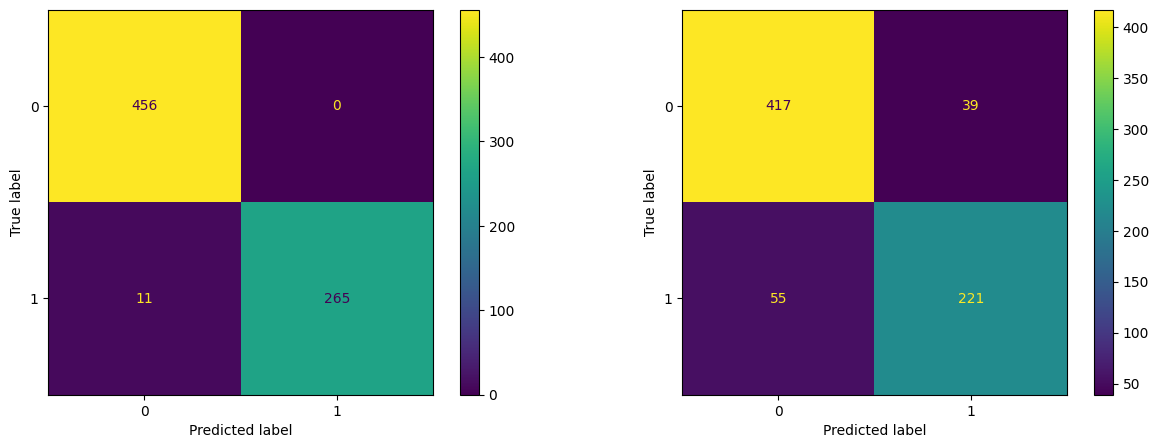

In [116]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

cm = confusion_matrix(y_tr, pred_v0)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax[0])

cm = confusion_matrix(y_tr, pred_v1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax[1])
plt.show()

In [117]:
import sklearn.metrics as mc

In [118]:
pd.DataFrame(modelV1_L.coef_, columns=X_tr.columns)

,pclass,gender,age,sibsp,parch,fare,age_decades,has_family,fare_div10,name_title,embarked_e
0,-0.873213,-3.286214,-0.01585,-0.354902,-0.456552,0.11235,-0.053355,0.33599,-1.080607,0.616514,0.0749


In [119]:
cm = pd.concat([pd.DataFrame(y_tr, index=y_tr.index), pd.DataFrame(pred_v0, index=y_tr.index, columns=["survived_1"])], axis=1)

In [120]:
cm.loc[cm["survived"] == cm["survived_1"]]

,survived,survived_1
38,0,0
304,1,1
360,0,0
506,0,0
695,0,0
...,...,...
579,0,0
124,1,1
450,0,0
94,0,0


In [121]:
false_negative = train.loc[cm.loc[(cm["survived"] == 1) & (cm["survived"] != cm["survived_1"])].index]
false_positive = train.loc[cm.loc[(cm["survived"] == 0) & (cm["survived"] != cm["survived_1"])].index]

In [122]:
false_negative

,survived,pclass,gender,age,sibsp,parch,fare,age_decades,has_family,fare_div10,name_title,embarked_e
503,1,3,1,39.000000,0,0,7.9250,3.0,0,0.0,1,1
71,1,3,1,24.073427,0,0,7.7750,2.0,0,0.0,1,1
736,1,3,1,32.000000,0,0,8.0500,3.0,0,0.0,1,1
133,1,3,1,21.000000,0,0,7.7958,2.0,0,0.0,1,1
62,1,3,1,24.073427,0,0,7.2292,2.0,0,0.0,1,3
374,1,3,1,24.073427,0,0,56.4958,2.0,0,5.0,1,1
582,1,3,1,32.000000,0,0,7.9250,3.0,0,0.0,1,1
793,1,3,1,19.000000,0,0,8.0500,1.0,0,0.0,1,1
311,1,3,1,24.073427,0,0,7.7500,2.0,0,0.0,1,2
735,1,3,1,22.000000,0,0,7.2250,2.0,0,0.0,1,3


<AxesSubplot: >

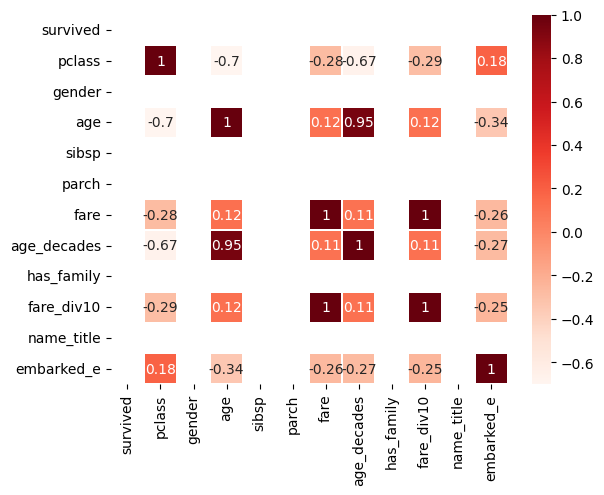

In [123]:
sns.heatmap(false_negative.corr(), annot=True, linewidths=0.2, cmap='Reds')

In [124]:
false_positive

,survived,pclass,gender,age,sibsp,parch,fare,age_decades,has_family,fare_div10,name_title,embarked_e


In [125]:
X_tr.loc[false_negative.index]

,pclass,gender,age,sibsp,parch,fare,age_decades,has_family,fare_div10,name_title,embarked_e
503,3,1,39.000000,0,0,7.9250,3.0,0,0.0,1,1
71,3,1,24.073427,0,0,7.7750,2.0,0,0.0,1,1
736,3,1,32.000000,0,0,8.0500,3.0,0,0.0,1,1
133,3,1,21.000000,0,0,7.7958,2.0,0,0.0,1,1
62,3,1,24.073427,0,0,7.2292,2.0,0,0.0,1,3
374,3,1,24.073427,0,0,56.4958,2.0,0,5.0,1,1
582,3,1,32.000000,0,0,7.9250,3.0,0,0.0,1,1
793,3,1,19.000000,0,0,8.0500,1.0,0,0.0,1,1
311,3,1,24.073427,0,0,7.7500,2.0,0,0.0,1,2
735,3,1,22.000000,0,0,7.2250,2.0,0,0.0,1,3


In [126]:
train.loc[(train["gender"] == 1) & (train["age"] >= 19) & (train["age"] < 45.5)].value_counts(["survived"])

survived
0           379
1            51
dtype: int64

이게 맞나?  
살아있는 사람 모으려고 만든건데 생사비율이 1:7인데?

In [127]:
def feature_template(df):
    df["mans"] = 0
    df.loc[(df["gender"] == 1) & (df["age"] >= 19) & (df["age"] < 45.5), "mans"] = 1
    return df

In [128]:
train["mans"] = 0
train.loc[(train["gender"] == 1) & (train["age"] >= 19) & (train["age"] < 45.5), "mans"] = 1
train

,survived,pclass,gender,age,sibsp,parch,fare,age_decades,has_family,fare_div10,name_title,embarked_e,mans
0,0,2,1,25.015625,0,0,12.8750,2.0,0,1.0,1,1,1
1,0,3,0,24.073427,0,0,7.7500,2.0,0,0.0,2,2,0
2,1,1,0,52.000000,1,1,93.5000,5.0,1,9.0,3,1,0
3,1,3,1,27.000000,0,0,7.7958,2.0,0,0.0,1,1,1
4,0,2,1,44.000000,1,0,26.0000,4.0,1,2.0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
911,0,3,1,24.073427,1,0,6.4375,2.0,1,0.0,1,3,1
912,0,3,1,18.000000,0,0,8.6625,1.0,0,0.0,1,1,0
913,0,2,1,19.000000,0,0,10.5000,1.0,0,1.0,1,1,1
914,1,3,0,24.073427,0,0,7.7333,2.0,0,0.0,2,2,0


In [129]:
test["mans"] = 0
test.loc[(test["gender"] == 1) & (test["age"] >= 19) & (test["age"] < 45.5), "mans"] = 1
test

,pclass,gender,age,sibsp,parch,fare,age_decades,has_family,fare_div10,name_title,embarked_e,mans
passengerid,,,,,,,,,,,,
916,3,0,15.0,0,0,8.0292,1.0,0,0.0,2,2,0
917,2,0,32.0,0,0,13.0000,3.0,0,1.0,3,1,0
918,3,0,0.0,0,0,7.7500,2.0,0,0.0,2,2,0
919,3,1,0.0,0,0,7.2500,2.0,0,0.0,1,1,0
920,1,0,45.0,1,1,164.8667,4.0,1,16.0,3,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1304,3,0,0.0,0,0,7.7500,2.0,0,0.0,2,2,0
1305,1,0,16.0,0,1,57.9792,1.0,1,5.0,2,3,0
1306,3,0,13.0,0,0,7.2292,1.0,0,0.0,2,3,0


In [130]:
feature_template(X_tr)
feature_template(X_te)

,pclass,gender,age,sibsp,parch,fare,age_decades,has_family,fare_div10,name_title,embarked_e,mans
485,1,1,28.000000,0,0,26.5500,2.0,0,2.0,1,1,1
745,1,0,49.000000,0,0,25.9292,4.0,0,2.0,4,1,0
634,2,1,32.000000,2,0,73.5000,3.0,1,7.0,1,1,1
722,3,0,4.153023,1,2,23.4500,0.0,1,2.0,3,1,0
137,1,0,37.000000,1,0,90.0000,3.0,1,9.0,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...
398,3,1,17.000000,0,0,7.8958,1.0,0,0.0,1,1,0
28,3,0,10.000000,5,2,46.9000,1.0,1,4.0,2,1,0
461,1,1,28.500000,0,0,27.7208,2.0,0,2.0,1,3,1
470,2,0,33.000000,0,2,26.0000,3.0,1,2.0,3,1,0


In [131]:
modelV2 = DecisionTreeClassifier(random_state=args["random_state"])
modelV2.fit(X_tr, y_tr)

DecisionTreeClassifier(random_state=21)

In [132]:
get_auc(modelV2, X_tr, y_tr), get_auc(modelV2, X_te, y_te)

(0.999372298499873, 0.7741854636591479)

In [133]:
confusion_matrix(y_tr, modelV2.predict(X_tr))

array([[456,   0],
       [ 11, 265]], dtype=int64)

In [134]:
pd.DataFrame(modelV2.feature_importances_, X_tr.columns).sort_values(by=[0], ascending=False)

,0
gender,0.511646
fare,0.172885
age,0.124645
pclass,0.056146
sibsp,0.029902
fare_div10,0.027613
embarked_e,0.023704
age_decades,0.018316
name_title,0.015905
parch,0.014699


일단 feature를 추가해보긴 했는데, 저 11개에서 뭘 더 따봐야 진전이 없을 듯하다...  
다른거부터 먼저 적용해보자.

# Model V3

> 스케일링이나 인코딩이 크게 효과가 없다는 증언들이 있어서, 앙상블을 먼저 적용해보자.

#### Random Forest

In [135]:
from sklearn import ensemble
from sklearn import metrics

In [136]:
modelV3_R = ensemble.RandomForestClassifier(random_state=args["random_state"])
modelV3_R.fit(X_tr, y_tr)

RandomForestClassifier(random_state=21)

In [137]:
get_auc(modelV3_R, X_tr, y_tr), get_auc(modelV3_R, X_te, y_te)

(0.9980294940249174, 0.8715538847117794)

In [138]:
scores.append({
    "date": datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"),
    "model": type(modelV3_R),
    "score": modelV3_R.score(X_te, y_te),
    "auc_score": get_auc(modelV3_R, X_te, y_te),
})
scores

[{'date': '2023/03/02 10:39:16',
  'model': sklearn.tree._classes.DecisionTreeClassifier,
  'score': 0.782608695652174,
  'auc_score': 0.7667293233082706},
 {'date': '2023/03/02 10:39:17',
  'model': sklearn.linear_model._logistic.LogisticRegression,
  'score': 0.8586956521739131,
  'auc_score': 0.8631578947368421},
 {'date': '2023/03/02 10:39:17',
  'model': sklearn.linear_model._coordinate_descent.ElasticNet,
  'score': 0.5048383618347885,
  'auc_score': 'ElasticNet has no proba'},
 {'date': '2023/03/02 10:39:21',
  'model': sklearn.ensemble._forest.RandomForestClassifier,
  'score': 0.8043478260869565,
  'auc_score': 0.8715538847117794}]

#### Boosting

In [139]:
modelV3_B = ensemble.GradientBoostingClassifier(random_state=args["random_state"])
modelV3_B.fit(X_tr, y_tr)

GradientBoostingClassifier(random_state=21)

In [140]:
get_auc(modelV3_B, X_tr, y_tr), get_auc(modelV3_B, X_te, y_te)

(0.9682216183574879, 0.8724310776942357)

In [141]:
scores.append({
    "date": datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"),
    "model": type(modelV3_B),
    "score": modelV3_B.score(X_te, y_te),
    "auc_score": get_auc(modelV3_B, X_te, y_te),
})
scores

[{'date': '2023/03/02 10:39:16',
  'model': sklearn.tree._classes.DecisionTreeClassifier,
  'score': 0.782608695652174,
  'auc_score': 0.7667293233082706},
 {'date': '2023/03/02 10:39:17',
  'model': sklearn.linear_model._logistic.LogisticRegression,
  'score': 0.8586956521739131,
  'auc_score': 0.8631578947368421},
 {'date': '2023/03/02 10:39:17',
  'model': sklearn.linear_model._coordinate_descent.ElasticNet,
  'score': 0.5048383618347885,
  'auc_score': 'ElasticNet has no proba'},
 {'date': '2023/03/02 10:39:21',
  'model': sklearn.ensemble._forest.RandomForestClassifier,
  'score': 0.8043478260869565,
  'auc_score': 0.8715538847117794},
 {'date': '2023/03/02 10:39:21',
  'model': sklearn.ensemble._gb.GradientBoostingClassifier,
  'score': 0.842391304347826,
  'auc_score': 0.8724310776942357}]

In [142]:
modelV3_Br = ensemble.GradientBoostingRegressor(random_state=args["random_state"])
modelV3_Br.fit(X_tr, y_tr)

GradientBoostingRegressor(random_state=21)

In [143]:
modelV3_Br.predict(X_te).shape

(184,)

In [144]:
modelV3_B.predict_proba(X_te).shape

(184, 2)

In [145]:
get_auc(modelV3_Br, X_tr, y_tr), get_auc(modelV3_Br, X_te, y_te)

(0.9662590579710145, 0.8784461152882206)

In [146]:
scores.append({
    "date": datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"),
    "model": type(modelV3_Br),
    "score": modelV3_Br.score(X_te, y_te),
    "auc_score": get_auc(modelV3_Br, X_te, y_te),
})
scores

[{'date': '2023/03/02 10:39:16',
  'model': sklearn.tree._classes.DecisionTreeClassifier,
  'score': 0.782608695652174,
  'auc_score': 0.7667293233082706},
 {'date': '2023/03/02 10:39:17',
  'model': sklearn.linear_model._logistic.LogisticRegression,
  'score': 0.8586956521739131,
  'auc_score': 0.8631578947368421},
 {'date': '2023/03/02 10:39:17',
  'model': sklearn.linear_model._coordinate_descent.ElasticNet,
  'score': 0.5048383618347885,
  'auc_score': 'ElasticNet has no proba'},
 {'date': '2023/03/02 10:39:21',
  'model': sklearn.ensemble._forest.RandomForestClassifier,
  'score': 0.8043478260869565,
  'auc_score': 0.8715538847117794},
 {'date': '2023/03/02 10:39:21',
  'model': sklearn.ensemble._gb.GradientBoostingClassifier,
  'score': 0.842391304347826,
  'auc_score': 0.8724310776942357},
 {'date': '2023/03/02 10:39:22',
  'model': sklearn.ensemble._gb.GradientBoostingRegressor,
  'score': 0.507206412492544,
  'auc_score': 0.8784461152882206}]

In [147]:
from xgboost import XGBClassifier

In [148]:
modelV3_X = XGBClassifier(random_state=args["random_state"])
modelV3_X.fit(X_tr, y_tr)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=21, ...)

In [149]:
get_auc(modelV3_X, X_tr, y_tr), get_auc(modelV3_X, X_te, y_te)

(0.9979897660818713, 0.8555764411027569)

In [150]:
hp = {
    "random_state" : args["random_state"],
    "max_depth" : 2,
    "n_estimators" : 100, # 수행할 부스팅 단계 수
    "learning_rate": 0.01,
    "min_child_weight": 2,
    "gamma": 3
}
modelV3_X = XGBClassifier(**hp).fit(X_tr, y_tr)
get_auc(modelV3_X, X_tr, y_tr), get_auc(modelV3_X, X_te, y_te)

(0.9061824624968218, 0.8832706766917293)

In [151]:
scores.append({
    "date": datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"),
    "model": type(modelV3_X),
    "score": modelV3_X.score(X_te, y_te),
    "auc_score": get_auc(modelV3_X, X_te, y_te),
})
scores

[{'date': '2023/03/02 10:39:16',
  'model': sklearn.tree._classes.DecisionTreeClassifier,
  'score': 0.782608695652174,
  'auc_score': 0.7667293233082706},
 {'date': '2023/03/02 10:39:17',
  'model': sklearn.linear_model._logistic.LogisticRegression,
  'score': 0.8586956521739131,
  'auc_score': 0.8631578947368421},
 {'date': '2023/03/02 10:39:17',
  'model': sklearn.linear_model._coordinate_descent.ElasticNet,
  'score': 0.5048383618347885,
  'auc_score': 'ElasticNet has no proba'},
 {'date': '2023/03/02 10:39:21',
  'model': sklearn.ensemble._forest.RandomForestClassifier,
  'score': 0.8043478260869565,
  'auc_score': 0.8715538847117794},
 {'date': '2023/03/02 10:39:21',
  'model': sklearn.ensemble._gb.GradientBoostingClassifier,
  'score': 0.842391304347826,
  'auc_score': 0.8724310776942357},
 {'date': '2023/03/02 10:39:22',
  'model': sklearn.ensemble._gb.GradientBoostingRegressor,
  'score': 0.507206412492544,
  'auc_score': 0.8784461152882206},
 {'date': '2023/03/02 10:39:23',
 

In [152]:
from xgboost import XGBRegressor

In [153]:
modelV3_Xr = XGBClassifier(random_state=args["random_state"])
modelV3_Xr.fit(X_tr, y_tr)
get_auc(modelV3_Xr, X_tr, y_tr), get_auc(modelV3_Xr, X_te, y_te)

(0.9979897660818713, 0.8555764411027569)

In [154]:
modelV3_Xr = XGBRegressor(random_state=args["random_state"])
modelV3_Xr.fit(X_tr, y_tr)
get_auc(modelV3_Xr, X_tr, y_tr), get_auc(modelV3_Xr, X_te, y_te)

(0.9992848970251716, 0.8457393483709273)

In [155]:
scores.append({
    "date": datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"),
    "model": type(modelV3_Xr),
    "score": modelV3_Xr.score(X_te, y_te),
    "auc_score": get_auc(modelV3_Xr, X_te, y_te),
})
scores

[{'date': '2023/03/02 10:39:16',
  'model': sklearn.tree._classes.DecisionTreeClassifier,
  'score': 0.782608695652174,
  'auc_score': 0.7667293233082706},
 {'date': '2023/03/02 10:39:17',
  'model': sklearn.linear_model._logistic.LogisticRegression,
  'score': 0.8586956521739131,
  'auc_score': 0.8631578947368421},
 {'date': '2023/03/02 10:39:17',
  'model': sklearn.linear_model._coordinate_descent.ElasticNet,
  'score': 0.5048383618347885,
  'auc_score': 'ElasticNet has no proba'},
 {'date': '2023/03/02 10:39:21',
  'model': sklearn.ensemble._forest.RandomForestClassifier,
  'score': 0.8043478260869565,
  'auc_score': 0.8715538847117794},
 {'date': '2023/03/02 10:39:21',
  'model': sklearn.ensemble._gb.GradientBoostingClassifier,
  'score': 0.842391304347826,
  'auc_score': 0.8724310776942357},
 {'date': '2023/03/02 10:39:22',
  'model': sklearn.ensemble._gb.GradientBoostingRegressor,
  'score': 0.507206412492544,
  'auc_score': 0.8784461152882206},
 {'date': '2023/03/02 10:39:23',
 

#### 제출하기

In [190]:
submission["survived"] = modelV3_R.predict_proba(test)[:,1]
submission.to_csv("../data/encore21titanic/submission_0227_R.csv", index=False, header=True)

In [156]:
submission["survived"] = modelV3_B.predict_proba(test)[:,1]
submission

,passengerid,survived
0,916,0.792486
1,917,0.947061
2,918,0.908096
3,919,0.087976
4,920,0.959206
...,...,...
388,1304,0.908096
389,1305,0.979080
390,1306,0.934804
391,1307,0.319129


In [157]:
submission.to_csv("../data/encore21titanic/submission_0227_B.csv", index=False, header=True)

In [158]:
submission["survived"] = modelV3_Br.predict(test)
submission

,passengerid,survived
0,916,0.737751
1,917,1.005991
2,918,0.803583
3,919,0.040202
4,920,0.897403
...,...,...
388,1304,0.803583
389,1305,1.000457
390,1306,0.958274
391,1307,0.303915


In [159]:
submission.to_csv("../data/encore21titanic/submission_0227_Br.csv", index=False, header=True)

In [160]:
submission["survived"] = modelV3_X.predict_proba(test)[:,1]
submission

,passengerid,survived
0,916,0.625333
1,917,0.779987
2,918,0.625333
3,919,0.311220
4,920,0.779987
...,...,...
388,1304,0.625333
389,1305,0.779987
390,1306,0.625333
391,1307,0.625333


In [161]:
submission.to_csv("../data/encore21titanic/submission_0227_X2.csv", index=False, header=True)

In [162]:
submission["survived"] = modelV3_Xr.predict(test)
submission

,passengerid,survived
0,916,0.620179
1,917,1.080627
2,918,0.936972
3,919,-0.019264
4,920,0.935167
...,...,...
388,1304,0.936972
389,1305,1.006621
390,1306,0.917163
391,1307,0.213866


In [163]:
submission.to_csv("../data/encore21titanic/submission_0227_Xr.csv", index=False, header=True)

# MODEL V4

> Cross validation 적용

In [164]:
from sklearn import svm
from sklearn import model_selection

In [165]:
cvscores = model_selection.cross_val_score(modelV3_Br, X_tr, y_tr, scoring=get_auc, cv=5)
print(f'각 검증 별 점수: \n{pd.Series(cvscores)}')
print(f'교차 검증 평균 점수: {np.mean(cvscores)}')

각 검증 별 점수: 
0    0.907880
1    0.942589
2    0.878869
3    0.907426
4    0.910927
dtype: float64
교차 검증 평균 점수: 0.9095382252744532


In [166]:
predict = model_selection.cross_val_predict(modelV3_Br, X_tr, y_tr, cv=10)
fpr, tpr, _ = roc_curve(y_tr, predict)
auc(fpr, tpr)

0.9036398741418763

In [167]:
result = model_selection.cross_validate(modelV3_Br, X_tr, y_tr, scoring=get_auc, cv=5, return_train_score=True)
pd.DataFrame(result)

,fit_time,score_time,test_score,train_score
0,0.074153,0.002096,0.907880,0.972305
1,0.076133,0.002997,0.942589,0.968332
2,0.056326,0.001991,0.878869,0.971970
3,0.051017,0.002648,0.907426,0.973097
4,0.050633,0.002010,0.910927,0.971669


적용은 해봤는데 이거 모델 생성용이 아니라 검증용이잖아...

# MODEL V5

> HPO 적용

Bayesian Search

In [168]:
from optuna.samplers import TPESampler
import optuna

목적 함수

In [169]:
class Objective:
    def __init__(self, x_train, y_train, seed):
        self.x_train = x_train
        self.y_train = y_train
        self.seed = seed
        num_folds = 5
        self.cv = model_selection.KFold(n_splits=num_folds, shuffle=True, random_state=self.seed)
    def __call__(self, trial):
        hp = {
            "random_state" : self.seed,
            "max_depth" : trial.suggest_int("max_depth", 2, 8),
            "n_estimators" : trial.suggest_int("n_estimators", 10, 500, 10), # 수행할 부스팅 단계 수
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 5),
            "gamma": trial.suggest_int("gamma", 1, 10)
        }
        model = XGBClassifier(**hp)
        scores = model_selection.cross_val_score(model, self.x_train, self.y_train, cv=self.cv, scoring="roc_auc")
        return np.mean(scores)

In [170]:
class Objective_r:
    def __init__(self, x_train, y_train, seed):
        self.x_train = x_train
        self.y_train = y_train
        self.seed = seed
        num_folds = 5
        self.cv = model_selection.KFold(n_splits=num_folds, shuffle=True, random_state=self.seed)
    def __call__(self, trial):
        hp = {
            "random_state" : self.seed,
            "max_depth" : trial.suggest_int("max_depth", 2, 8),
            "n_estimators" : trial.suggest_int("n_estimators", 10, 500, 10), # 수행할 부스팅 단계 수
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 5),
            "gamma": trial.suggest_int("gamma", 1, 10)
        }
        model = XGBRegressor(**hp)
        scores = model_selection.cross_val_score(model, self.x_train, self.y_train, cv=self.cv, scoring="roc_auc")
        return np.mean(scores)

## 학습

xgboost classifier

In [171]:
sampler = TPESampler(seed=args["random_state"])

study = optuna.create_study(
    direction="maximize",
    sampler=sampler
)
objective = Objective(X_tr, y_tr, args.random_state)
study.optimize(objective, n_trials=50)

[I 2023-03-02 10:39:26,503] A new study created in memory with name: no-name-7d85e34e-167c-41b7-af53-d005c48920d8
[I 2023-03-02 10:39:26,752] Trial 0 finished with value: 0.9104691856434662 and parameters: {'max_depth': 2, 'n_estimators': 150, 'learning_rate': 0.0748869712148107, 'min_child_weight': 1, 'gamma': 3}. Best is trial 0 with value: 0.9104691856434662.
[I 2023-03-02 10:39:27,044] Trial 1 finished with value: 0.9085615405639483 and parameters: {'max_depth': 2, 'n_estimators': 160, 'learning_rate': 0.069751926516223, 'min_child_weight': 2, 'gamma': 6}. Best is trial 0 with value: 0.9104691856434662.
[I 2023-03-02 10:39:27,632] Trial 2 finished with value: 0.9138756710921312 and parameters: {'max_depth': 2, 'n_estimators': 440, 'learning_rate': 0.0219916467326573, 'min_child_weight': 1, 'gamma': 5}. Best is trial 2 with value: 0.9138756710921312.
[I 2023-03-02 10:39:28,512] Trial 3 finished with value: 0.9083290308064779 and parameters: {'max_depth': 8, 'n_estimators': 380, 'lea

In [172]:
print(f"Best score: {study.best_value} at trial {study.best_trial.number}\nBest parameters:\n{study.best_params}")

Best score: 0.9139158156124042 at trial 25
Best parameters:
{'max_depth': 2, 'n_estimators': 260, 'learning_rate': 0.05718054544093286, 'min_child_weight': 1, 'gamma': 5}


In [173]:
modelV5 = XGBClassifier(random_state=args["random_state"], **study.best_params)
modelV5.fit(X_tr, y_tr)

get_auc(modelV5, X_te, y_te)

0.8812030075187971

In [174]:
scores.append({
    "date": datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"),
    "model": type(modelV5),
    "score": modelV5.score(X_te, y_te),
    "auc_score": get_auc(modelV5, X_te, y_te)
})
scores

[{'date': '2023/03/02 10:39:16',
  'model': sklearn.tree._classes.DecisionTreeClassifier,
  'score': 0.782608695652174,
  'auc_score': 0.7667293233082706},
 {'date': '2023/03/02 10:39:17',
  'model': sklearn.linear_model._logistic.LogisticRegression,
  'score': 0.8586956521739131,
  'auc_score': 0.8631578947368421},
 {'date': '2023/03/02 10:39:17',
  'model': sklearn.linear_model._coordinate_descent.ElasticNet,
  'score': 0.5048383618347885,
  'auc_score': 'ElasticNet has no proba'},
 {'date': '2023/03/02 10:39:21',
  'model': sklearn.ensemble._forest.RandomForestClassifier,
  'score': 0.8043478260869565,
  'auc_score': 0.8715538847117794},
 {'date': '2023/03/02 10:39:21',
  'model': sklearn.ensemble._gb.GradientBoostingClassifier,
  'score': 0.842391304347826,
  'auc_score': 0.8724310776942357},
 {'date': '2023/03/02 10:39:22',
  'model': sklearn.ensemble._gb.GradientBoostingRegressor,
  'score': 0.507206412492544,
  'auc_score': 0.8784461152882206},
 {'date': '2023/03/02 10:39:23',
 

In [175]:
optuna.visualization.plot_param_importances(study)

xgboost regressor

In [176]:
sampler = TPESampler(seed=args["random_state"])

study = optuna.create_study(
    direction="maximize",
    sampler=sampler
)
objective = Objective_r(X_tr, y_tr, args["random_state"])
study.optimize(objective, n_trials=50)

[I 2023-03-02 10:39:56,991] A new study created in memory with name: no-name-8bb9c9e8-7dfe-469d-ab1c-4e5642c3c69c
[I 2023-03-02 10:39:57,234] Trial 0 finished with value: 0.9042091327286247 and parameters: {'max_depth': 2, 'n_estimators': 150, 'learning_rate': 0.0748869712148107, 'min_child_weight': 1, 'gamma': 3}. Best is trial 0 with value: 0.9042091327286247.
[I 2023-03-02 10:39:57,495] Trial 1 finished with value: 0.8620254819997941 and parameters: {'max_depth': 2, 'n_estimators': 160, 'learning_rate': 0.069751926516223, 'min_child_weight': 2, 'gamma': 6}. Best is trial 0 with value: 0.9042091327286247.
[I 2023-03-02 10:39:58,201] Trial 2 finished with value: 0.8684904369751265 and parameters: {'max_depth': 2, 'n_estimators': 440, 'learning_rate': 0.0219916467326573, 'min_child_weight': 1, 'gamma': 5}. Best is trial 0 with value: 0.9042091327286247.
[I 2023-03-02 10:39:59,621] Trial 3 finished with value: 0.8992213403462987 and parameters: {'max_depth': 8, 'n_estimators': 380, 'lea

In [177]:
print(f"Best score: {study.best_value} at trial {study.best_trial.number}\nBest parameters:\n{study.best_params}")

Best score: 0.9074375816943224 at trial 13
Best parameters:
{'max_depth': 6, 'n_estimators': 320, 'learning_rate': 0.0434333605972955, 'min_child_weight': 2, 'gamma': 1}


In [178]:
modelV5_Xr = XGBRegressor(random_state=args["random_state"], **study.best_params)
modelV5_Xr.fit(X_tr, y_tr)

get_auc(modelV5_Xr, X_te, y_te)

0.8777568922305764

In [179]:
scores.append({
    "date": datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"),
    "model": type(modelV5_Xr),
    "score": modelV5_Xr.score(X_te, y_te),
    "auc_score": get_auc(modelV5_Xr, X_te, y_te)
})
scores

[{'date': '2023/03/02 10:39:16',
  'model': sklearn.tree._classes.DecisionTreeClassifier,
  'score': 0.782608695652174,
  'auc_score': 0.7667293233082706},
 {'date': '2023/03/02 10:39:17',
  'model': sklearn.linear_model._logistic.LogisticRegression,
  'score': 0.8586956521739131,
  'auc_score': 0.8631578947368421},
 {'date': '2023/03/02 10:39:17',
  'model': sklearn.linear_model._coordinate_descent.ElasticNet,
  'score': 0.5048383618347885,
  'auc_score': 'ElasticNet has no proba'},
 {'date': '2023/03/02 10:39:21',
  'model': sklearn.ensemble._forest.RandomForestClassifier,
  'score': 0.8043478260869565,
  'auc_score': 0.8715538847117794},
 {'date': '2023/03/02 10:39:21',
  'model': sklearn.ensemble._gb.GradientBoostingClassifier,
  'score': 0.842391304347826,
  'auc_score': 0.8724310776942357},
 {'date': '2023/03/02 10:39:22',
  'model': sklearn.ensemble._gb.GradientBoostingRegressor,
  'score': 0.507206412492544,
  'auc_score': 0.8784461152882206},
 {'date': '2023/03/02 10:39:23',
 

In [180]:
optuna.visualization.plot_param_importances(study)

In [181]:
import shap

In [183]:
explainer = shap.TreeExplainer(modelV3_Xr)
shap_values = explainer.shap_values(X_te)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[-1,:], X_te.iloc[-1,:])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


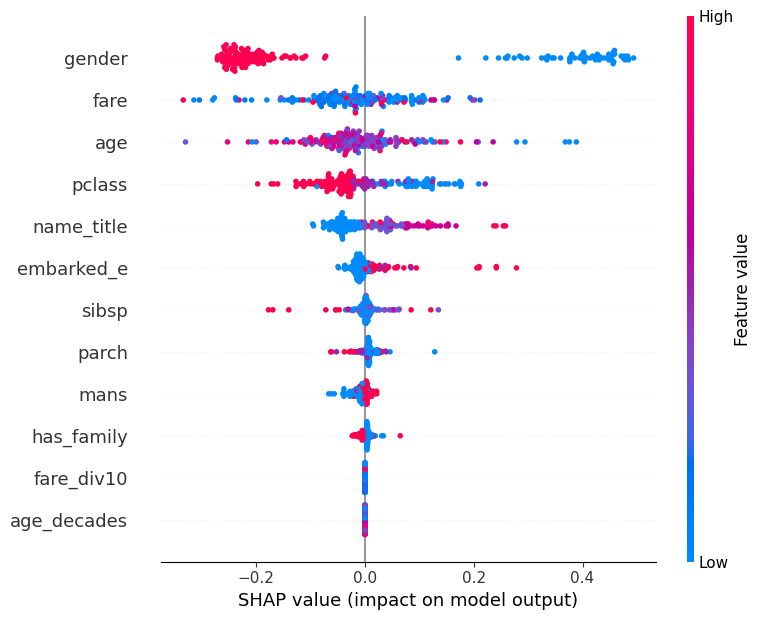

In [184]:
shap.summary_plot(shap_values, X_te)

제출하기

In [185]:
submission["survived"] = modelV5.predict_proba(test)[:,1]

In [186]:
submission.to_csv("../data/encore21titanic/submission_0228_X.csv", index=False, header=True)

In [187]:
submission["survived"] = modelV5_Xr.predict(test)

In [188]:
submission.to_csv("../data/encore21titanic/submission_0228_Xr_2.csv", index=False, header=True)

# MODEL V6

> 아저씨 뭔 하이퍼파라미터여 다시 EDA나 해

## sibsp & parch

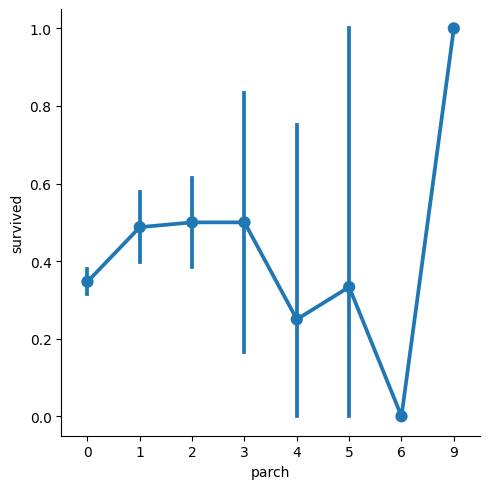

In [200]:
sns.catplot(data=ori_train, x="parch", y="survived", kind="point")

In [204]:
train["families"] = train["sibsp"] + train["parch"]

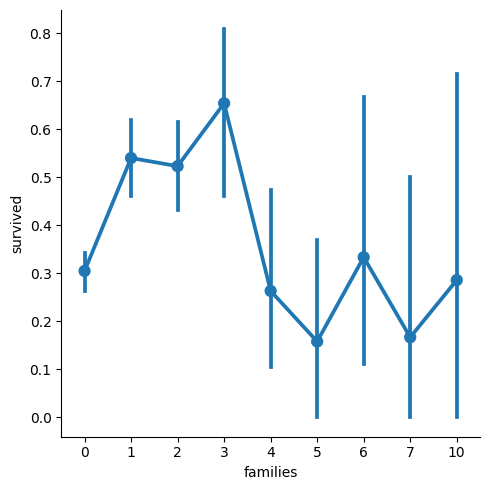

In [205]:
sns.catplot(data=train, x="families", y="survived", kind="point")

In [206]:
train["families"]

0      0
1      0
2      2
3      0
4      1
      ..
911    1
912    0
913    0
914    0
915    0
Name: families, Length: 916, dtype: int64

In [214]:
train["families_cat"] = train.apply(lambda x: 0 if x["families"] == 0 else 1 if x["families"] <= 3 else 2, axis=1)
train.head()

,survived,pclass,gender,age,sibsp,parch,fare,age_decades,has_family,fare_div10,name_title,embarked_e,mans,families,families_cat
0,0,2,1,25.015625,0,0,12.8750,2.0,0,1.0,1,1,1,0,0
1,0,3,0,24.073427,0,0,7.7500,2.0,0,0.0,2,2,0,0,0
2,1,1,0,52.000000,1,1,93.5000,5.0,1,9.0,3,1,0,2,1
3,1,3,1,27.000000,0,0,7.7958,2.0,0,0.0,1,1,1,0,0
4,0,2,1,44.000000,1,0,26.0000,4.0,1,2.0,1,1,1,1,1


In [218]:
X_tr["families"] = X_tr["sibsp"] + X_tr["parch"]
X_tr["families_cat"] = X_tr.apply(lambda x: 0 if x["families"] == 0 else 1 if x["families"] <= 3 else 2, axis=1)
X_tr.drop("families", axis=1, inplace=True)

,pclass,gender,age,sibsp,parch,fare,age_decades,has_family,fare_div10,name_title,embarked_e,mans,families_cat
38,2,1,18.000000,0,0,11.500,1.0,0,1.0,1,1,0,0
304,1,0,17.000000,1,0,57.000,1.0,1,5.0,3,1,0,1
360,3,0,25.000000,1,0,7.925,2.0,1,0.0,2,1,0,1
506,3,1,24.073427,0,0,7.775,2.0,0,0.0,1,1,1,0
695,3,1,32.000000,0,0,7.925,3.0,0,0.0,1,1,1,0


In [219]:
X_te["families"] = X_te["sibsp"] + X_te["parch"]
X_te["families_cat"] = X_te.apply(lambda x: 0 if x["families"] == 0 else 1 if x["families"] <= 3 else 2, axis=1)
X_te.drop("families", axis=1, inplace=True)

,pclass,gender,age,sibsp,parch,fare,age_decades,has_family,fare_div10,name_title,embarked_e,mans,families_cat
485,1,1,28.000000,0,0,26.5500,2.0,0,2.0,1,1,1,0
745,1,0,49.000000,0,0,25.9292,4.0,0,2.0,4,1,0,0
634,2,1,32.000000,2,0,73.5000,3.0,1,7.0,1,1,1,1
722,3,0,4.153023,1,2,23.4500,0.0,1,2.0,3,1,0,1
137,1,0,37.000000,1,0,90.0000,3.0,1,9.0,3,2,0,1


In [220]:
test["families"] = test["sibsp"] + test["parch"]
test["families_cat"] = test.apply(lambda x: 0 if x["families"] == 0 else 1 if x["families"] <= 3 else 2, axis=1)
test.drop("families", axis=1, inplace=True)

,pclass,gender,age,sibsp,parch,fare,age_decades,has_family,fare_div10,name_title,embarked_e,mans,families_cat
passengerid,,,,,,,,,,,,,
916,3,0,15.0,0,0,8.0292,1.0,0,0.0,2,2,0,0
917,2,0,32.0,0,0,13.0000,3.0,0,1.0,3,1,0,0
918,3,0,0.0,0,0,7.7500,2.0,0,0.0,2,2,0,0
919,3,1,0.0,0,0,7.2500,2.0,0,0.0,1,1,0,0
920,1,0,45.0,1,1,164.8667,4.0,1,16.0,3,1,0,1


In [222]:
modelV6_Xr = XGBRegressor(random_state=args["random_state"])
modelV6_Xr.fit(X_tr, y_tr)
get_auc(modelV6_Xr, X_tr, y_tr), get_auc(modelV6_Xr, X_te, y_te)

(0.9993246249682176, 0.8393483709273182)

In [223]:
sampler = TPESampler(seed=args["random_state"])

study = optuna.create_study(
    direction="maximize",
    sampler=sampler
)
objective = Objective_r(X_tr, y_tr, args["random_state"])
study.optimize(objective, n_trials=50)
print(f"Best score: {study.best_value} at trial {study.best_trial.number}\nBest parameters:\n{study.best_params}")

[I 2023-03-02 12:50:08,711] A new study created in memory with name: no-name-a9c5cc12-df5f-473e-b5cc-7aec5ca899f6
[I 2023-03-02 12:50:09,009] Trial 0 finished with value: 0.9046626348915876 and parameters: {'max_depth': 2, 'n_estimators': 150, 'learning_rate': 0.0748869712148107, 'min_child_weight': 1, 'gamma': 3}. Best is trial 0 with value: 0.9046626348915876.
[I 2023-03-02 12:50:09,344] Trial 1 finished with value: 0.8641376171764454 and parameters: {'max_depth': 2, 'n_estimators': 160, 'learning_rate': 0.069751926516223, 'min_child_weight': 2, 'gamma': 6}. Best is trial 0 with value: 0.9046626348915876.
[I 2023-03-02 12:50:10,177] Trial 2 finished with value: 0.8731611110761861 and parameters: {'max_depth': 2, 'n_estimators': 440, 'learning_rate': 0.0219916467326573, 'min_child_weight': 1, 'gamma': 5}. Best is trial 0 with value: 0.9046626348915876.
[I 2023-03-02 12:50:11,501] Trial 3 finished with value: 0.8966545859813835 and parameters: {'max_depth': 8, 'n_estimators': 380, 'lea

Best score: 0.9089931416982205 at trial 23
Best parameters:
{'max_depth': 6, 'n_estimators': 200, 'learning_rate': 0.03533802199952851, 'min_child_weight': 2, 'gamma': 1}


In [224]:
modelV6_Xr_H = XGBRegressor(random_state=args["random_state"], **study.best_params)
modelV6_Xr_H.fit(X_tr, y_tr)

get_auc(modelV6_Xr_H, X_tr, y_tr), get_auc(modelV6_Xr_H, X_te, y_te)

(0.9230271103483345, 0.8777568922305764)

In [225]:
scores.append({
    "date": datetime.datetime.now().strftime("%Y/%m/%d %H:%M:%S"),
    "model": type(modelV6_Xr_H),
    "score": modelV6_Xr_H.score(X_te, y_te),
    "auc_score": get_auc(modelV6_Xr_H, X_te, y_te)
})
scores

[{'date': '2023/03/02 10:39:16',
  'model': sklearn.tree._classes.DecisionTreeClassifier,
  'score': 0.782608695652174,
  'auc_score': 0.7667293233082706},
 {'date': '2023/03/02 10:39:17',
  'model': sklearn.linear_model._logistic.LogisticRegression,
  'score': 0.8586956521739131,
  'auc_score': 0.8631578947368421},
 {'date': '2023/03/02 10:39:17',
  'model': sklearn.linear_model._coordinate_descent.ElasticNet,
  'score': 0.5048383618347885,
  'auc_score': 'ElasticNet has no proba'},
 {'date': '2023/03/02 10:39:21',
  'model': sklearn.ensemble._forest.RandomForestClassifier,
  'score': 0.8043478260869565,
  'auc_score': 0.8715538847117794},
 {'date': '2023/03/02 10:39:21',
  'model': sklearn.ensemble._gb.GradientBoostingClassifier,
  'score': 0.842391304347826,
  'auc_score': 0.8724310776942357},
 {'date': '2023/03/02 10:39:22',
  'model': sklearn.ensemble._gb.GradientBoostingRegressor,
  'score': 0.507206412492544,
  'auc_score': 0.8784461152882206},
 {'date': '2023/03/02 10:39:23',
 

제출하기

In [226]:
submission["survived"] = modelV6_Xr.predict(test)
submission.to_csv("../data/encore21titanic/submission_0302_Xr.csv", index=False, header=True)

In [227]:
submission["survived"] = modelV6_Xr_H.predict(test)
submission.to_csv("../data/encore21titanic/submission_0302_Xr_H.csv", index=False, header=True)

# MODEL V7

One-Hot Endcoding 적용

In [231]:
X_tr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 732 entries, 38 to 277
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   pclass        732 non-null    int64  
 1   gender        732 non-null    int64  
 2   age           732 non-null    float64
 3   sibsp         732 non-null    int64  
 4   parch         732 non-null    int64  
 5   fare          732 non-null    float64
 6   age_decades   732 non-null    float64
 7   has_family    732 non-null    int64  
 8   fare_div10    732 non-null    float64
 9   name_title    732 non-null    int64  
 10  embarked_e    732 non-null    int64  
 11  mans          732 non-null    int64  
 12  families_cat  732 non-null    int64  
dtypes: float64(4), int64(9)
memory usage: 96.2 KB


In [233]:
onehot_cols = ["pclass", "gender", "families_cat", "mans", "name_title", "embarked_e"]

In [236]:
import category_encoders as ce

In [237]:
encoder = ce.OneHotEncoder(use_cat_names=True)

In [239]:
X_tr_b = X_tr.copy()
X_te_b = X_te.copy()

In [278]:
X_tr = X_tr_b.copy()
X_te = X_te_b.copy()

In [279]:
for col in onehot_cols:
    _enco = encoder.fit_transform(X_tr[col].astype('category'))
    X_tr = pd.concat([X_tr, _enco], axis=1)

    _enco = encoder.transform(X_te[col].astype('category'))
    X_te = pd.concat([X_te, _enco], axis=1)

    _enco = encoder.transform(test[col].astype('category'))
    test = pd.concat([test, _enco], axis=1)

print((X_tr.shape, X_te.shape, test.shape))
X_tr

((732, 30), (184, 30), (393, 30))


,pclass,gender,age,sibsp,parch,fare,age_decades,has_family,fare_div10,name_title,...,families_cat_2.0,mans_0.0,mans_1.0,name_title_1.0,name_title_3.0,name_title_2.0,name_title_4.0,embarked_e_1.0,embarked_e_3.0,embarked_e_2.0
38,2,1,18.000000,0,0,11.5000,1.0,0,1.0,1,...,0,1,0,1,0,0,0,1,0,0
304,1,0,17.000000,1,0,57.0000,1.0,1,5.0,3,...,0,1,0,0,1,0,0,1,0,0
360,3,0,25.000000,1,0,7.9250,2.0,1,0.0,2,...,0,1,0,0,0,1,0,1,0,0
506,3,1,24.073427,0,0,7.7750,2.0,0,0.0,1,...,0,0,1,1,0,0,0,1,0,0
695,3,1,32.000000,0,0,7.9250,3.0,0,0.0,1,...,0,0,1,1,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579,1,1,18.000000,1,0,108.9000,1.0,1,10.0,1,...,0,1,0,1,0,0,0,0,1,0
124,1,1,49.000000,1,0,89.1042,4.0,1,8.0,1,...,0,1,0,1,0,0,0,0,1,0
450,1,1,42.000000,0,0,26.5500,4.0,0,2.0,1,...,0,0,1,1,0,0,0,1,0,0
94,3,1,2.000000,4,1,39.6875,0.0,1,3.0,4,...,1,1,0,0,0,0,1,1,0,0


In [280]:
X_tr.drop(onehot_cols, axis=1, inplace=True)
X_te.drop(onehot_cols, axis=1, inplace=True)
test.drop(onehot_cols, axis=1, inplace=True)

In [281]:
modelV7_Xr = XGBRegressor(random_state=args["random_state"])
modelV7_Xr.fit(X_tr, y_tr)
get_auc(modelV7_Xr, X_tr, y_tr), get_auc(modelV7_Xr, X_te, y_te)

(0.9993246249682177, 0.8383458646616542)

In [255]:
sampler = TPESampler(seed=args["random_state"])

study = optuna.create_study(
    direction="maximize",
    sampler=sampler
)
objective = Objective_r(X_tr, y_tr, args["random_state"])
study.optimize(objective, n_trials=50)
print(f"Best score: {study.best_value} at trial {study.best_trial.number}\nBest parameters:\n{study.best_params}")

[I 2023-03-02 16:13:05,407] A new study created in memory with name: no-name-62a3fa56-9fbe-4c0d-857e-900b3a627cad
[I 2023-03-02 16:13:05,830] Trial 0 finished with value: 0.9046626348915876 and parameters: {'max_depth': 2, 'n_estimators': 150, 'learning_rate': 0.0748869712148107, 'min_child_weight': 1, 'gamma': 3}. Best is trial 0 with value: 0.9046626348915876.
[I 2023-03-02 16:13:06,193] Trial 1 finished with value: 0.8641376171764454 and parameters: {'max_depth': 2, 'n_estimators': 160, 'learning_rate': 0.069751926516223, 'min_child_weight': 2, 'gamma': 6}. Best is trial 0 with value: 0.9046626348915876.
[I 2023-03-02 16:13:07,011] Trial 2 finished with value: 0.8731611110761861 and parameters: {'max_depth': 2, 'n_estimators': 440, 'learning_rate': 0.0219916467326573, 'min_child_weight': 1, 'gamma': 5}. Best is trial 0 with value: 0.9046626348915876.
[I 2023-03-02 16:13:08,551] Trial 3 finished with value: 0.8966545859813835 and parameters: {'max_depth': 8, 'n_estimators': 380, 'lea

Best score: 0.9089570404812054 at trial 41
Best parameters:
{'max_depth': 6, 'n_estimators': 290, 'learning_rate': 0.03886129009581887, 'min_child_weight': 2, 'gamma': 1}


In [291]:
explainer = shap.TreeExplainer(modelV7_Xr)
shap_values = explainer.shap_values(X_tr)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[-1,:], X_tr.iloc[-1,:])

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


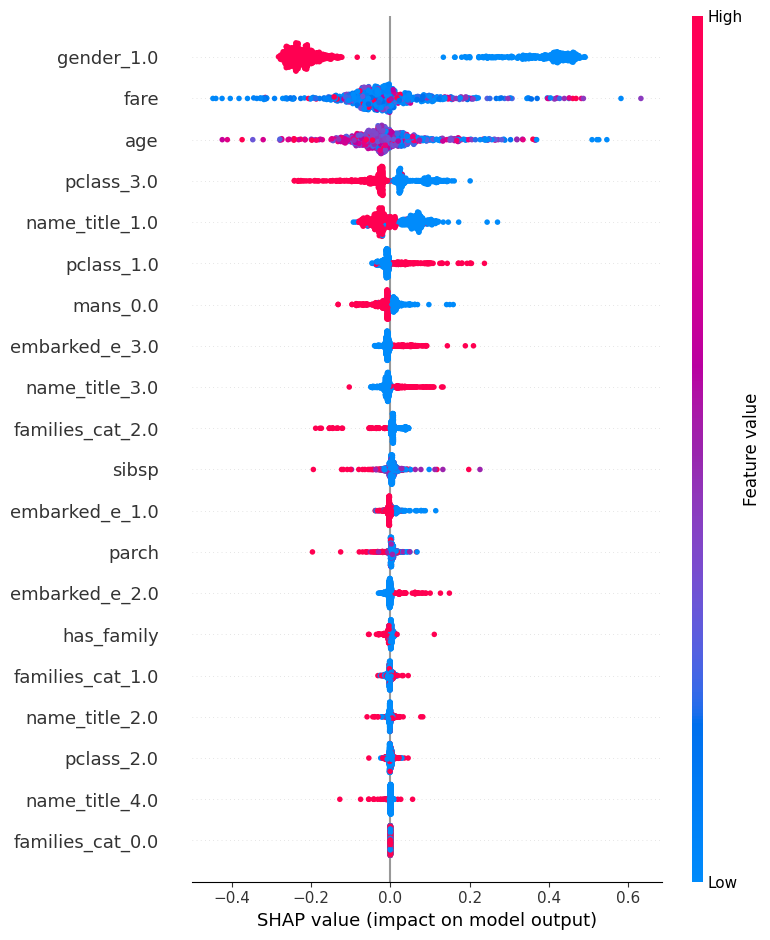

In [292]:
shap.summary_plot(shap_values, X_tr)

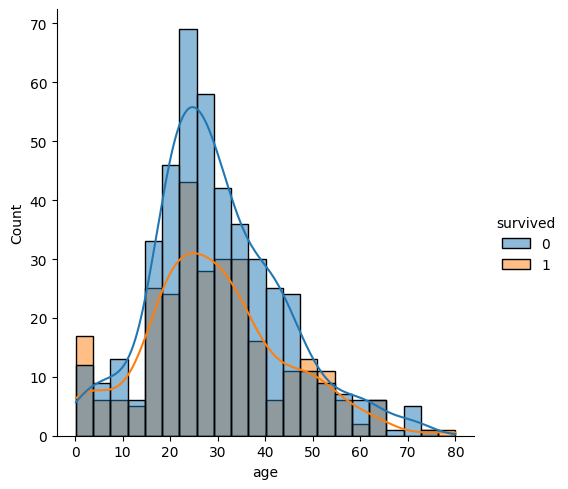

In [303]:
sns.displot(data=ori_train, x="age", hue="survived", kde=True)

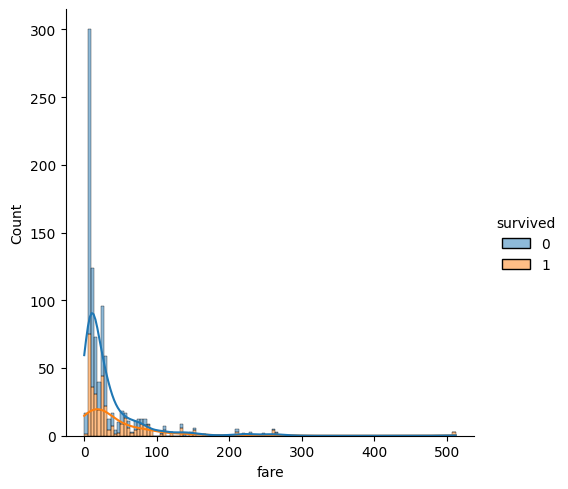

In [314]:
sns.displot(data=ori_train, x="fare", hue="survived", kde=True, multiple="stack")

<AxesSubplot: xlabel='fare', ylabel='age'>

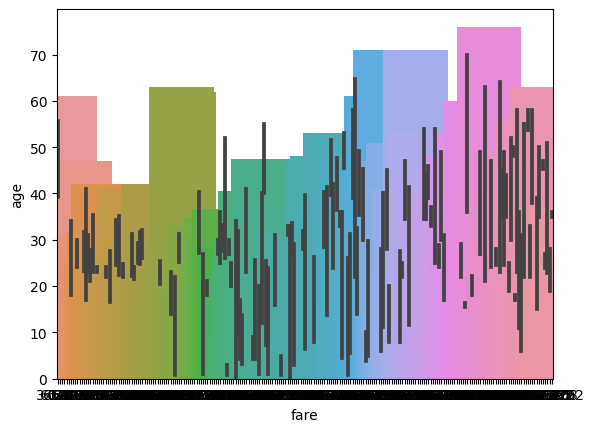

In [401]:
sns.barplot(data=X_tr, x="fare", y="age", estimator="mean", width=30)

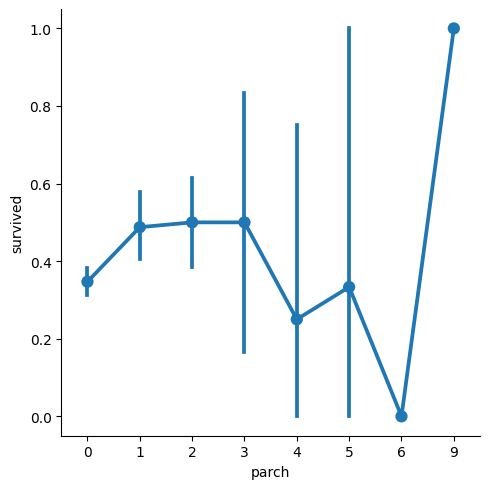

In [322]:
sns.catplot(data=ori_train, x="parch", y="survived", kind="point")

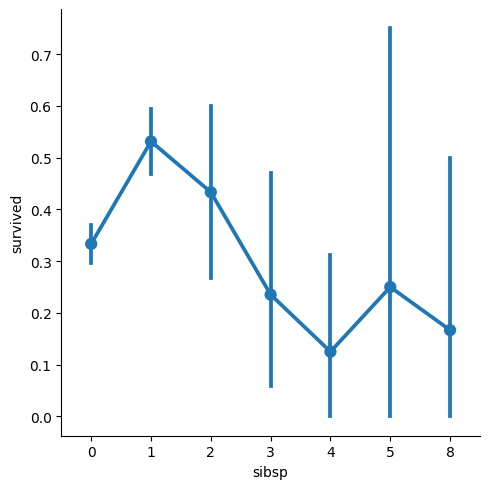

In [316]:
sns.catplot(data=ori_train, x="sibsp", y="survived", kind="point")

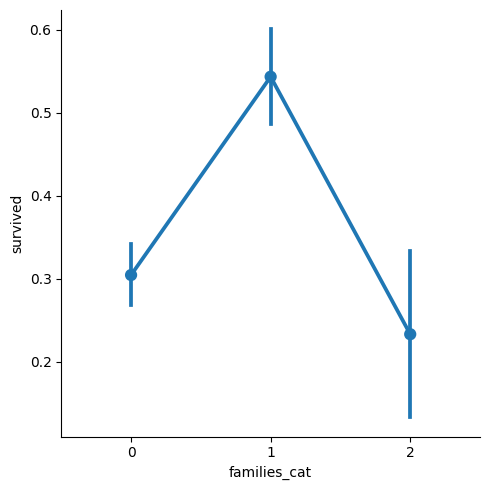

In [301]:
sns.catplot(data=train, x="families_cat", y="survived", kind="point")

In [323]:
for df in [X_tr, X_te, test]:
    df["parch_cat"] = df.apply(lambda x: 0 if x["parch"] == 0 else 1 if x["parch"] <= 3 else 2, axis=1)
    df["sibsp_cat"] = df.apply(lambda x: 0 if x["sibsp"] == 0 else 1 if x["sibsp"] <= 2 else 2, axis=1)
    print(df.shape)


(732, 26)
(184, 26)
(393, 26)


In [ ]:
onehot_cols = ["parch_cat", "sibsp_cat"]
encoder = ce.OneHotEncoder(use_cat_names=True)
for col in onehot_cols:
    _enco = encoder.fit_transform(X_tr[col].astype('category'))
    X_tr = pd.concat([X_tr, _enco], axis=1)

    _enco = encoder.transform(X_te[col].astype('category'))
    X_te = pd.concat([X_te, _enco], axis=1)

    _enco = encoder.transform(test[col].astype('category'))
    test = pd.concat([test, _enco], axis=1)

X_tr.drop(onehot_cols+["sibsp", "parch"], axis=1, inplace=True)
X_te.drop(onehot_cols+["sibsp", "parch"], axis=1, inplace=True)
test.drop(onehot_cols+["sibsp", "parch"], axis=1, inplace=True)

In [330]:
X_tr.columns

Index(['age', 'fare', 'age_decades', 'has_family', 'fare_div10', 'pclass_2.0',
       'pclass_1.0', 'pclass_3.0', 'gender_1.0', 'gender_0.0',
       'families_cat_0.0', 'families_cat_1.0', 'families_cat_2.0', 'mans_0.0',
       'mans_1.0', 'name_title_1.0', 'name_title_3.0', 'name_title_2.0',
       'name_title_4.0', 'embarked_e_1.0', 'embarked_e_3.0', 'embarked_e_2.0',
       'parch_cat_0.0', 'parch_cat_1.0', 'parch_cat_2.0', 'sibsp_cat_0.0',
       'sibsp_cat_1.0', 'sibsp_cat_2.0'],
      dtype='object')

In [332]:
modelV7_XC = XGBClassifier(random_state=args["random_state"])
modelV7_XC.fit(X_tr, y_tr)
get_auc(modelV7_XC, X_tr, y_tr), get_auc(modelV7_XC, X_te, y_te)

(0.9978308543096873, 0.8510651629072682)

In [333]:
sampler = TPESampler(seed=args["random_state"])

study = optuna.create_study(
    direction="maximize",
    sampler=sampler
)
objective = Objective_r(X_tr, y_tr, args["random_state"])
study.optimize(objective, n_trials=50)
print(f"Best score: {study.best_value} at trial {study.best_trial.number}\nBest parameters:\n{study.best_params}")

[I 2023-03-02 17:42:37,557] A new study created in memory with name: no-name-e82f7edd-7738-4226-b801-8e52c62735a2
[I 2023-03-02 17:42:37,920] Trial 0 finished with value: 0.9046626348915876 and parameters: {'max_depth': 2, 'n_estimators': 150, 'learning_rate': 0.0748869712148107, 'min_child_weight': 1, 'gamma': 3}. Best is trial 0 with value: 0.9046626348915876.
[I 2023-03-02 17:42:38,279] Trial 1 finished with value: 0.8641376171764454 and parameters: {'max_depth': 2, 'n_estimators': 160, 'learning_rate': 0.069751926516223, 'min_child_weight': 2, 'gamma': 6}. Best is trial 0 with value: 0.9046626348915876.
[I 2023-03-02 17:42:39,120] Trial 2 finished with value: 0.8731611110761861 and parameters: {'max_depth': 2, 'n_estimators': 440, 'learning_rate': 0.0219916467326573, 'min_child_weight': 1, 'gamma': 5}. Best is trial 0 with value: 0.9046626348915876.
[I 2023-03-02 17:42:40,801] Trial 3 finished with value: 0.8966545859813835 and parameters: {'max_depth': 8, 'n_estimators': 380, 'lea

Best score: 0.9099068878307393 at trial 24
Best parameters:
{'max_depth': 7, 'n_estimators': 190, 'learning_rate': 0.054101297770570315, 'min_child_weight': 1, 'gamma': 1}


In [334]:
modelV7_XC_H = XGBClassifier(random_state=args["random_state"], **study.best_params)
modelV7_XC_H.fit(X_tr, y_tr)
get_auc(modelV7_XC_H, X_tr, y_tr), get_auc(modelV7_XC_H, X_te, y_te)

(0.9765168128654971, 0.8684837092731831)

제출하기

In [ ]:
submission["survived"] = modelV7_Xr.predict(test)
submission.to_csv("../data/encore21titanic/submission_0302_Xr_e.csv", index=False, header=True)

In [335]:
submission["survived"] = modelV7_XC.predict_proba(test)[:,1]
submission.to_csv("../data/encore21titanic/submission_0302_XC.csv", index=False, header=True)

In [336]:
submission["survived"] = modelV7_XC_H.predict_proba(test)[:,1]
submission.to_csv("../data/encore21titanic/submission_0302_XC_H.csv", index=False, header=True)

In [337]:
submission

,passengerid,survived
0,916,0.676659
1,917,0.968806
2,918,0.872972
3,919,0.083361
4,920,0.934741
...,...,...
388,1304,0.872972
389,1305,0.981872
390,1306,0.858806
391,1307,0.120172


threshold 변경해보기

In [369]:
threshold = 0.4
pred_v0 = np.array([1 if x > threshold else 0 for x in modelV7_XC.predict_proba(X_tr)[:,1]])
pred_v1 = np.array([1 if x > threshold else 0 for x in modelV7_XC_H.predict_proba(X_tr)[:,1]])

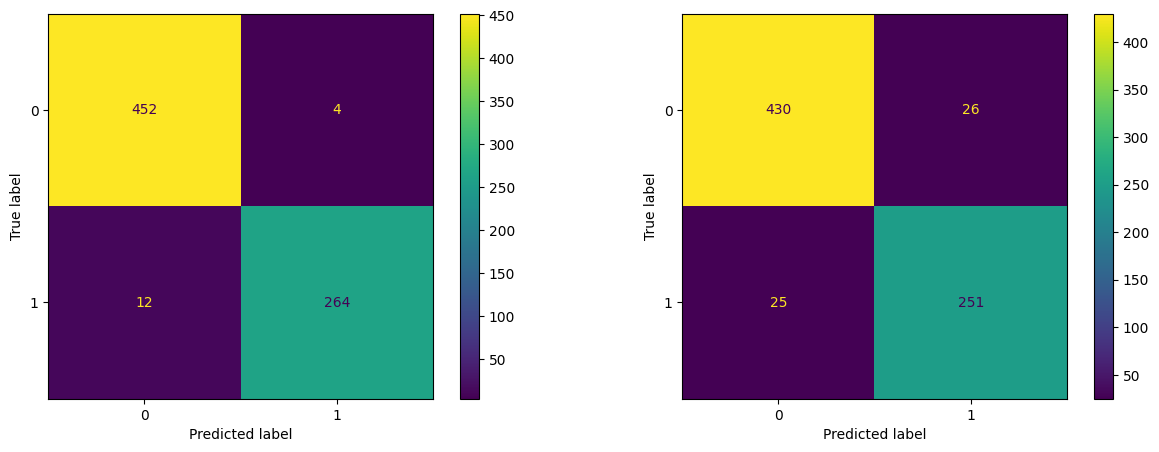

In [370]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

cm = confusion_matrix(y_tr, pred_v0)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax[0])

cm = confusion_matrix(y_tr, pred_v1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax[1])
plt.show()

In [372]:
print(threshold)
for x in [pred_v0, pred_v1]:
    fpr, tpr, _ = roc_curve(y_tr, x)
    print(auc(fpr, tpr))

0.4
0.9738749046529367
0.9262013729977117


In [ ]:
threshold = 0.4
pred_v0 = np.array([1 if x > threshold else 0 for x in modelV7_XC.predict_proba(X_tr)[:,1]])
pred_v1 = np.array([1 if x > threshold else 0 for x in modelV7_XC_H.predict_proba(X_tr)[:,1]])

print(threshold)
for x in [pred_v0, pred_v1]:
    fpr, tpr, _ = roc_curve(y_tr, x)
    print(auc(fpr, tpr))

In [374]:
for threshold in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    pred_v0 = np.array([1 if x > threshold else 0 for x in modelV7_XC.predict_proba(X_tr)[:,1]])
    pred_v1 = np.array([1 if x > threshold else 0 for x in modelV7_XC_H.predict_proba(X_tr)[:,1]])
    aucs = []
    for x in [pred_v0, pred_v1]:
        fpr, tpr, _ = roc_curve(y_tr, x)
        aucs.append(auc(fpr, tpr))
    print(f"{threshold} / {aucs[0]} / {aucs[1]}")

0.1 / 0.9067982456140351 / 0.826468344774981
0.2 / 0.9583810068649884 / 0.9030320366132724
0.3 / 0.9715865751334859 / 0.921386346300534
0.4 / 0.9738749046529367 / 0.9262013729977117
0.5 / 0.9746376811594203 / 0.9172387490465292
0.6 / 0.9673913043478262 / 0.8908276125095347
0.7 / 0.9565217391304348 / 0.8829138062547673
0.8 / 0.9329710144927537 / 0.8554061784897026
0.9 / 0.875 / 0.7952898550724637


In [375]:
for threshold in [0.31, 0.32, 0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39]:
    pred_v0 = np.array([1 if x > threshold else 0 for x in modelV7_XC.predict_proba(X_tr)[:,1]])
    pred_v1 = np.array([1 if x > threshold else 0 for x in modelV7_XC_H.predict_proba(X_tr)[:,1]])
    aucs = []
    for x in [pred_v0, pred_v1]:
        fpr, tpr, _ = roc_curve(y_tr, x)
        aucs.append(auc(fpr, tpr))
    print(f"{threshold} / {aucs[0]} / {aucs[1]}")

0.31 / 0.9737795575896262 / 0.922482837528604
0.32 / 0.9748760488176964 / 0.922482837528604
0.33 / 0.9748760488176964 / 0.9235793287566744
0.34 / 0.9763539282990086 / 0.9235793287566744
0.35 / 0.9763539282990086 / 0.9250572082379863
0.36 / 0.97563882532418 / 0.9261536994660564
0.37 / 0.9760202135774219 / 0.9261536994660564
0.38 / 0.9782131960335622 / 0.9283466819221967
0.39 / 0.9738749046529367 / 0.9276315789473684


또 제출하기

In [380]:
submission["survived"] = np.array([1 if x > 0.38 else 0 for x in modelV7_XC_H.predict_proba(test)[:,1]])
submission.to_csv("../data/encore21titanic/submission_0302_XC_H_t.csv", index=False, header=True)